# Environment setup

In [0]:
# Connect to Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
# Copy the dataset from Google Drive to local

!cp "/content/gdrive/My Drive/CBIS_DDSM.zip" .
!unzip -qq CBIS_DDSM.zip
!rm CBIS_DDSM.zip
cbis_path = 'CBIS_DDSM'

In [0]:
# Import libraries

%tensorflow_version 1.x
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Adadelta, Adagrad, Adamax, Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model

# Data pre-processing

In [0]:
def load_training():
    """
    Load the training set (excluding baseline patches)
    """
    images = np.load(os.path.join(cbis_path, 'numpy data', 'train_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'train_labels.npy'))[1::2]
    return images, labels


def load_testing():
    """
    Load the test set (abnormalities patches and labels, no baseline)
    """
    images = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_labels.npy'))[1::2]
    return images, labels


def remap_label(l):
    """
    Remap the labels to 0->mass 1->calcification
    """
    if l == 1 or l == 2:
        return 0
    elif l == 3 or l == 4:
        return 1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None

The data is prepared following these steps:


1.   Import the training and testing data from numpy arrays
2.   Remove the images and labels related to baseline patches (even indices in the arrays)
3.   Adjust the labels for the binary classification problem, so that 0 corresponds to 'mass' and 1 maps to 'calcification'
4.   Normalize the pixels to be in the range (0-1) floating point
5.   Shuffle the training set (and labels accordingly, of course)
6.   Split the training data into 'training' and 'validation' subsets
7.   Build Keras generators for training and validation data



In [0]:
# Load training and test images (abnormalities only, no baseline)
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

# Number of images
n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

# Compute width and height of images
img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

# Remap labels
train_labels = np.array([remap_label(l) for l in train_labels])
test_labels = np.array([remap_label(l) for l in test_labels])

# Create a new dimension for color in the images arrays
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

# Convert from 16-bit (0-65535) to float (0-1)
train_images = train_images.astype('uint16') / 65535
test_images = test_images.astype('uint16') / 65535

# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(n_train_img)
train_images = train_images[perm]
train_labels = train_labels[perm]

# Create a generator for training images
train_datagen = ImageDataGenerator(
    validation_split=0.2
)

# Fit the generator with some images
train_datagen.fit(train_images)

# Split train images into actual training and validation
train_generator = train_datagen.flow(train_images, train_labels, batch_size=32, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=32, subset='validation')

Train size: 2676 	 Test size: 336
Image size: 150x150


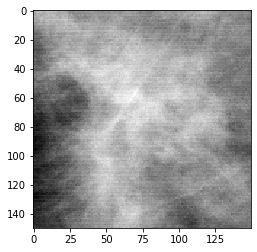

Label: 0


In [0]:
# Visualize one image from the dataset and its label, just to make sure the data format is correct

idx = 0

plt.imshow(train_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(train_labels[idx]))

# Classification

The first step is to discover how large the model should be approximately. A network that is too small won't be able to generalize well; on the other side, a model with too many parameters may learn slowly and overfit.

A good way to find the appropriate size is to start from a small naive model, then gradually increase its size until it starts overfitting while learning; at that point it is flexible enough to fit the training data, and potentially generalizable to other data with a proper training.

Of course, the model can be refined later, by adding new layers, modifying existing ones, including regularization techniques or tuning the hyperparameters, in order to achieve (hopefully) better performances.

## Experiment 0

Let's start with a very small CNN, made of 2 convolutional layers interleaved with max-pooling. At the end, after a fully-connect layer, a single neuron with sigmoid activation generates the output (binary classification).

As already mentioned, the aim is to get a rough idea of the required model complexity.

In [0]:
# Build a simple model

model_0 = models.Sequential()
model_0.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model_0.add(layers.MaxPooling2D((2, 2)))
model_0.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_0.add(layers.MaxPooling2D((2, 2)))
model_0.add(layers.Flatten())
model_0.add(layers.Dense(16, activation='relu'))
model_0.add(layers.Dense(1, activation='sigmoid'))

model_0.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 82944)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1327120   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

The loss function is the binary cross-entropy, which is particularly suitable for this kind of problem (binary classification). The optimizer is RMSprop, an adaptive optimization algorithm which is considered quite efficient.
During the training, we monitor how the loss evolves on the validation set too and save the corresponding model weights when that loss is minimum, since it is where the model usually performs best.

In [0]:
# Callback for checkpointing
checkpoint = ModelCheckpoint('model_0_2cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
model_0.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_0 = model_0.fit_generator(
        train_generator,
        steps_per_epoch=int(0.8*n_train_img) // 32,
        epochs=100,
        validation_data=validation_generator,
        callbacks=[checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save
models.save_model(model_0, 'model_0_2cl_end.h5')
!cp model* "/content/gdrive/My Drive/models/"

Epoch 1/100
17/66 [======>.......................] - ETA: 1s - loss: 0.6947 - acc: 0.4953
Epoch 00001: val_loss improved from inf to 0.69468, saving model to model_0_2cl_best.h5
66/66 [==============================] - 4s 64ms/step - loss: 0.7068 - acc: 0.5562 - val_loss: 0.6947 - val_acc: 0.4953
Epoch 2/100
17/66 [======>.......................] - ETA: 0s - loss: 0.6349 - acc: 0.6953
Epoch 00002: val_loss improved from 0.69468 to 0.63495, saving model to model_0_2cl_best.h5
66/66 [==============================] - 3s 43ms/step - loss: 0.6684 - acc: 0.5913 - val_loss: 0.6349 - val_acc: 0.6953
Epoch 3/100
17/66 [======>.......................] - ETA: 0s - loss: 0.7692 - acc: 0.5402
Epoch 00003: val_loss did not improve from 0.63495
66/66 [==============================] - 3s 43ms/step - loss: 0.6336 - acc: 0.6567 - val_loss: 0.7692 - val_acc: 0.5402
Epoch 4/100
17/66 [======>.......................] - ETA: 0s - loss: 0.7253 - acc: 0.5701
Epoch 00004: val_loss did not improve from 0.6349

In [0]:
# History of accuracy and loss
tra_loss_0 = history_0.history['loss']
tra_acc_0 = history_0.history['acc']
val_loss_0 = history_0.history['val_loss']
val_acc_0 = history_0.history['val_acc']

# Total number of epochs training
epochs_0 = range(1, len(tra_acc_0)+1)
end_epoch_0 = len(tra_acc_0)

# Epoch when reached the validation loss minimum
opt_epoch_0 = val_loss_0.index(min(val_loss_0)) + 1

# Loss and accuracy on the validation set
end_val_loss_0 = val_loss_0[-1]
end_val_acc_0 = val_acc_0[-1]
opt_val_loss_0 = val_loss_0[opt_epoch_0-1]
opt_val_acc_0 = val_acc_0[opt_epoch_0-1]

# Loss and accuracy on the test set
opt_model_0 = models.load_model('model_0_2cl_best.h5')
test_loss_0, test_acc_0 = model_0.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_0, opt_test_acc_0 = opt_model_0.evaluate(test_images, test_labels, verbose=False)
opt_pred_0 = opt_model_0.predict([test_images, test_labels])
pred_classes_0 = np.rint(opt_pred_0)

print("Model 0\n")

print("Epoch [end]: %d" % end_epoch_0)
print("Epoch [opt]: %d" % opt_epoch_0)
print("Valid accuracy [end]: %.4f" % end_val_acc_0)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_0)
print("Test accuracy [end]:  %.4f" % test_acc_0)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_0)
print("Valid loss [end]: %.4f" % end_val_loss_0)
print("Valid loss [opt]: %.4f" % opt_val_loss_0)
print("Test loss [end]:  %.4f" % test_loss_0)
print("Test loss [opt]:  %.4f" % opt_test_loss_0)

print(classification_report(test_labels, pred_classes_0, digits=4))

Model 0

Epoch [end]: 100
Epoch [opt]: 13
Valid accuracy [end]: 0.8243
Valid accuracy [opt]: 0.8150
Test accuracy [end]:  0.7827
Test accuracy [opt]:  0.7738
Valid loss [end]: 1.4127
Valid loss [opt]: 0.4460
Test loss [end]:  2.1665
Test loss [opt]:  0.5247
              precision    recall  f1-score   support

           0     0.7943    0.7765    0.7853       179
           1     0.7516    0.7707    0.7610       157

    accuracy                         0.7738       336
   macro avg     0.7729    0.7736    0.7732       336
weighted avg     0.7743    0.7738    0.7740       336



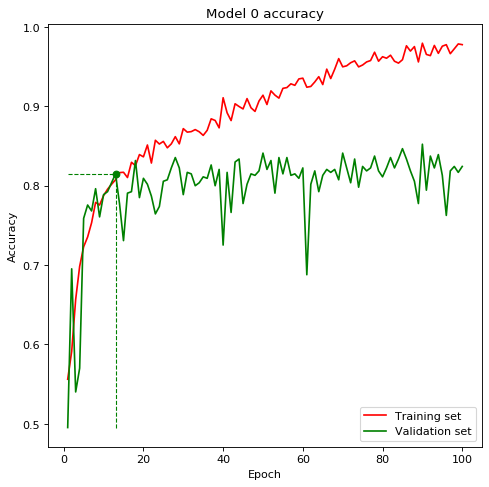

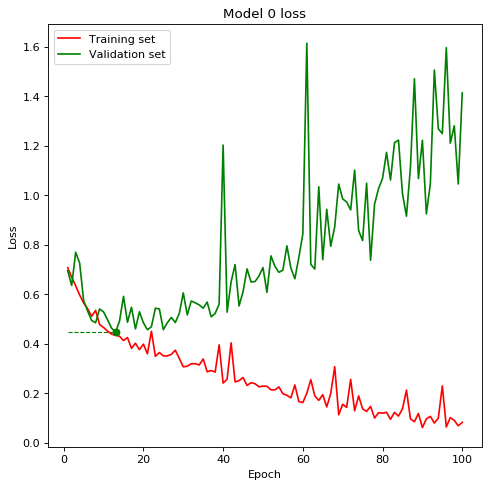

In [0]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 0 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_0, tra_acc_0, 'r', label='Training set')
plt.plot(epochs_0, val_acc_0, 'g', label='Validation set')
plt.plot(opt_epoch_0, val_acc_0[opt_epoch_0-1], 'go')
plt.vlines(opt_epoch_0, min(val_acc_0), opt_val_acc_0, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_0, 1, opt_epoch_0, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 0 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_0, tra_loss_0, 'r', label='Training set')
plt.plot(epochs_0, val_loss_0, 'g', label='Validation set')
plt.plot(opt_epoch_0, val_loss_0[opt_epoch_0-1], 'go')
plt.vlines(opt_epoch_0, min(val_loss_0), opt_val_loss_0, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_0, 1, opt_epoch_0, linestyle="dashed", color='g', linewidth=1)
plt.legend();

**Result**: the network learned relatively fast, and eventually reached an almost perfect classification on the training dataset, which of course does not mean it is good at classifying other data. Indeed, the accuracy achieved on the validation set was 81.5\%, with a 77.4\% on the test set. Indeed, the model severely overfits, mainly due to the limited dataset (only 2000 images for 1.3 million of weights) and lack of regularization methods.
Nonetheless, it is a promising initial result and a good starting point for subsequent models.
This experiment proves that very deep architectures are not strictly needed in this task to achieve good results. Clearly, larger and deeper models may help in the classification of more difficult samples, it is yet to be proven.

## Experiment 1

The priority now is to mitigate the hard overfitting observed in the previous experiment, which prevents the network from finding a good general combination of weights.

Model 1 is just like the previous one, but with the addition of a ***Dropout*** layer after the final fully-connected block. Dropout is a powerful regularization technique that is often employed to reduce overfitting. It consists in ignoring a randomly chosen fraction of the previous layer neurons at every iteration in the training phase; this encourages the network to find an alternate and redundant representations for the inputs, ultimately leading to better performance. The dropout rate is set to 0.5, a value considered to be optimal by the author themselves in the original paper.

In [0]:
# Model 1

model_1 = models.Sequential()
model_1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Flatten())
model_1.add(layers.Dense(16, activation='relu'))
model_1.add(layers.Dropout(0.5))
model_1.add(layers.Dense(1, activation='sigmoid'))

model_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 82944)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                1327120   
_________________________________________________________________
dropout (Dropout)            (None, 16)               

In [0]:
# Callback for checkpointing
checkpoint = ModelCheckpoint('model_1_2cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
model_1.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_1 = model_1.fit_generator(
        train_generator,
        steps_per_epoch=int(0.8*n_train_img) // 32,
        epochs=100,
        validation_data=validation_generator,
        callbacks=[checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save
models.save_model(model_1, 'model_1_2cl_end.h5')
!cp model* "/content/gdrive/My Drive/models/"

Epoch 1/100
16/66 [======>.......................] - ETA: 1s - loss: 0.6923 - acc: 0.5254
Epoch 00001: val_loss improved from inf to 0.69243, saving model to model_1_2cl_best.h5
66/66 [==============================] - 5s 70ms/step - loss: 0.7383 - acc: 0.5353 - val_loss: 0.6924 - val_acc: 0.5215
Epoch 2/100
17/66 [======>.......................] - ETA: 0s - loss: 0.6979 - acc: 0.5159
Epoch 00002: val_loss did not improve from 0.69243
66/66 [==============================] - 3s 42ms/step - loss: 0.6920 - acc: 0.5510 - val_loss: 0.6979 - val_acc: 0.5159
Epoch 3/100
17/66 [======>.......................] - ETA: 0s - loss: 0.7038 - acc: 0.5196
Epoch 00003: val_loss did not improve from 0.69243
66/66 [==============================] - 3s 42ms/step - loss: 0.6892 - acc: 0.5448 - val_loss: 0.7038 - val_acc: 0.5196
Epoch 4/100
17/66 [======>.......................] - ETA: 0s - loss: 0.7060 - acc: 0.5215
Epoch 00004: val_loss did not improve from 0.69243
66/66 [==============================] 

In [0]:
# History of accuracy and loss
tra_loss_1 = history_1.history['loss']
tra_acc_1 = history_1.history['acc']
val_loss_1 = history_1.history['val_loss']
val_acc_1 = history_1.history['val_acc']

# Total number of epochs training
epochs_1 = range(1, len(tra_acc_1)+1)
end_epoch_1 = len(tra_acc_1)

# Epoch when reached the validation loss minimum
opt_epoch_1 = val_loss_1.index(min(val_loss_1)) + 1

# Loss and accuracy on the validation set
end_val_loss_1 = val_loss_1[-1]
end_val_acc_1 = val_acc_1[-1]
opt_val_loss_1 = val_loss_1[opt_epoch_1-1]
opt_val_acc_1 = val_acc_1[opt_epoch_1-1]

# Loss and accuracy on the test set
opt_model_1 = models.load_model('model_1_2cl_best.h5')
test_loss_1, test_acc_1 = model_1.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_1, opt_test_acc_1 = opt_model_1.evaluate(test_images, test_labels, verbose=False)
opt_pred_1 = opt_model_1.predict([test_images, test_labels])
pred_classes_1 = np.rint(opt_pred_1)

print("Model 1\n")

print("Epoch [end]: %d" % end_epoch_1)
print("Epoch [opt]: %d" % opt_epoch_1)
print("Valid accuracy [end]: %.4f" % end_val_acc_1)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_1)
print("Test accuracy [end]:  %.4f" % test_acc_1)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_1)
print("Valid loss [end]: %.4f" % end_val_loss_1)
print("Valid loss [opt]: %.4f" % opt_val_loss_1)
print("Test loss [end]:  %.4f" % test_loss_1)
print("Test loss [opt]:  %.4f" % opt_test_loss_1)

print(classification_report(test_labels, pred_classes_1, digits=4))

Model 1

Epoch [end]: 100
Epoch [opt]: 52
Valid accuracy [end]: 0.8187
Valid accuracy [opt]: 0.8393
Test accuracy [end]:  0.7679
Test accuracy [opt]:  0.8065
Valid loss [end]: 0.4717
Valid loss [opt]: 0.3837
Test loss [end]:  0.6619
Test loss [opt]:  0.6088
              precision    recall  f1-score   support

           0     0.8000    0.8492    0.8238       179
           1     0.8151    0.7580    0.7855       157

    accuracy                         0.8065       336
   macro avg     0.8075    0.8036    0.8047       336
weighted avg     0.8070    0.8065    0.8059       336



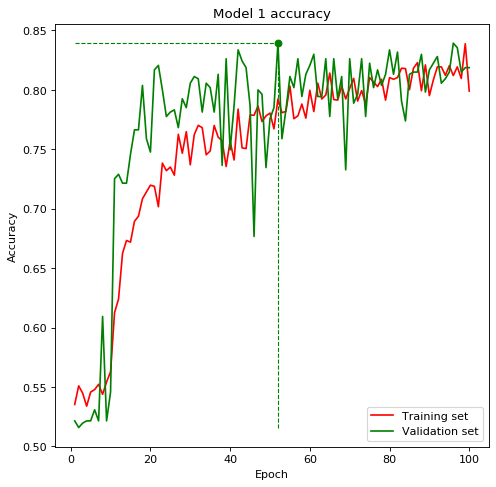

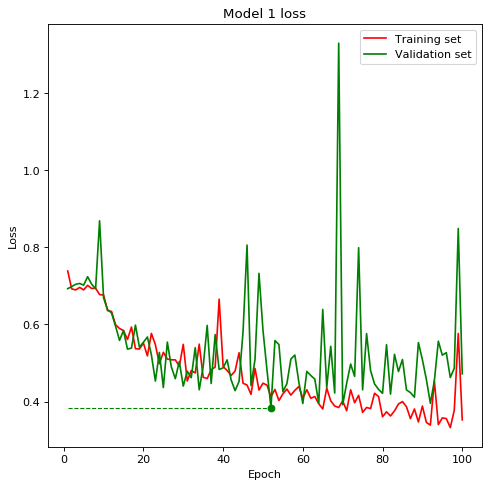

In [0]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 1 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_1, tra_acc_1, 'r', label='Training set')
plt.plot(epochs_1, val_acc_1, 'g', label='Validation set')
plt.plot(opt_epoch_1, val_acc_1[opt_epoch_1-1], 'go')
plt.vlines(opt_epoch_1, min(val_acc_1), opt_val_acc_1, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_1, 1, opt_epoch_1, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 1 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_1, tra_loss_1, 'r', label='Training set')
plt.plot(epochs_1, val_loss_1, 'g', label='Validation set')
plt.plot(opt_epoch_1, val_loss_1[opt_epoch_1-1], 'go')
plt.vlines(opt_epoch_1, min(val_loss_1), opt_val_loss_1, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_1, 1, opt_epoch_1, linestyle="dashed", color='g', linewidth=1)
plt.legend();

**Result**: The only addition of a Dropout layer greatly reduced the overfitting w.r.t the previous experiment, but without completely eliminating it.
Now that the effect of overfitting was less disruptive, the network managed to improve its accuracy as well.

## Experiment 2

Before changing the architectural layout, another regularization method is applied to the previous model to further mitigate overfitting: ***data augmentation***. With data augmentation, the network is trained with a higher number of different samples, generated by applying predefined transformations to the original data. Common techniques are image flipping, shifting, rotation, scaling, distortion, noise injection.

In order to exploit data augmentation, the Keras image generator must be reinitialized with proper arguments. 
As proposed in other studies, we use these augmentation methods:

*   Flipping (horizontal and vertical)
*   Rotation (angle between 0 and 180 degrees)
*   Shear (10 deg)
*   Scale (0.2)



In [0]:
# Create a generator for training images
train_datagen = ImageDataGenerator(
    validation_split=0.2,
    rotation_range=180,
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

# Fit the generator with some images
train_datagen.fit(train_images)

# Split train images into actual training and validation
train_generator = train_datagen.flow(train_images, train_labels, batch_size=32, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=32, subset='validation')

In [0]:
# Model 2

model_2 = models.Sequential()
model_2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Flatten())
model_2.add(layers.Dense(16, activation='relu'))
model_2.add(layers.Dropout(0.5))
model_2.add(layers.Dense(1, activation='sigmoid'))

model_2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 82944)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                1327120   
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)               

In [0]:
# Callback for checkpointing
checkpoint = ModelCheckpoint('model_2_2cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
model_2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_2 = model_2.fit_generator(
        train_generator,
        steps_per_epoch=int(0.8*n_train_img) // 32,
        epochs=100,
        validation_data=validation_generator,
        callbacks=[checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save
models.save_model(model_2, 'model_2_2cl_end.h5')
!cp model* "/content/gdrive/My Drive/models/"

Epoch 1/100
16/66 [======>.......................] - ETA: 3s - loss: 0.6934 - acc: 0.5273
Epoch 00001: val_loss improved from inf to 0.69355, saving model to model_2_2cl_best.h5
66/66 [==============================] - 7s 112ms/step - loss: 0.7312 - acc: 0.5382 - val_loss: 0.6935 - val_acc: 0.5215
Epoch 2/100
16/66 [======>.......................] - ETA: 3s - loss: 0.6962 - acc: 0.5273
Epoch 00002: val_loss did not improve from 0.69355
66/66 [==============================] - 6s 94ms/step - loss: 0.6923 - acc: 0.5453 - val_loss: 0.6960 - val_acc: 0.5215
Epoch 3/100
16/66 [======>.......................] - ETA: 3s - loss: 0.6955 - acc: 0.5254
Epoch 00003: val_loss did not improve from 0.69355
66/66 [==============================] - 6s 96ms/step - loss: 0.6885 - acc: 0.5401 - val_loss: 0.6968 - val_acc: 0.5215
Epoch 4/100
16/66 [======>.......................] - ETA: 3s - loss: 0.7034 - acc: 0.5254
Epoch 00004: val_loss did not improve from 0.69355
66/66 [==============================]

In [0]:
# History of accuracy and loss
tra_loss_2 = history_2.history['loss']
tra_acc_2 = history_2.history['acc']
val_loss_2 = history_2.history['val_loss']
val_acc_2 = history_2.history['val_acc']

# Total number of epochs training
epochs_2 = range(1, len(tra_acc_2)+1)
end_epoch_2 = len(tra_acc_2)

# Epoch when reached the validation loss minimum
opt_epoch_2 = val_loss_2.index(min(val_loss_2)) + 1

# Loss and accuracy on the validation set
end_val_loss_2 = val_loss_2[-1]
end_val_acc_2 = val_acc_2[-1]
opt_val_loss_2 = val_loss_2[opt_epoch_2-1]
opt_val_acc_2 = val_acc_2[opt_epoch_2-1]

# Loss and accuracy on the test set
opt_model_2 = models.load_model('model_2_2cl_best.h5')
test_loss_2, test_acc_2 = model_2.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_2, opt_test_acc_2 = opt_model_2.evaluate(test_images, test_labels, verbose=False)
opt_pred_2 = opt_model_2.predict([test_images, test_labels])
pred_classes_2 = np.rint(opt_pred_2)

print("Model 2\n")

print("Epoch [end]: %d" % end_epoch_2)
print("Epoch [opt]: %d" % opt_epoch_2)
print("Valid accuracy [end]: %.4f" % end_val_acc_2)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_2)
print("Test accuracy [end]:  %.4f" % test_acc_2)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_2)
print("Valid loss [end]: %.4f" % end_val_loss_2)
print("Valid loss [opt]: %.4f" % opt_val_loss_2)
print("Test loss [end]:  %.4f" % test_loss_2)
print("Test loss [opt]:  %.4f" % opt_test_loss_2)

print(classification_report(test_labels, pred_classes_2, digits=4))

Model 2

Epoch [end]: 100
Epoch [opt]: 87
Valid accuracy [end]: 0.7925
Valid accuracy [opt]: 0.8056
Test accuracy [end]:  0.8006
Test accuracy [opt]:  0.7976
Valid loss [end]: 0.4821
Valid loss [opt]: 0.4458
Test loss [end]:  0.4945
Test loss [opt]:  0.4999
              precision    recall  f1-score   support

           0     0.7534    0.9218    0.8291       179
           1     0.8803    0.6561    0.7518       157

    accuracy                         0.7976       336
   macro avg     0.8169    0.7889    0.7905       336
weighted avg     0.8127    0.7976    0.7930       336



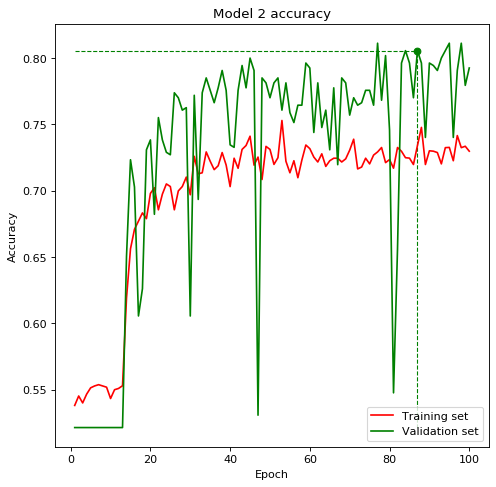

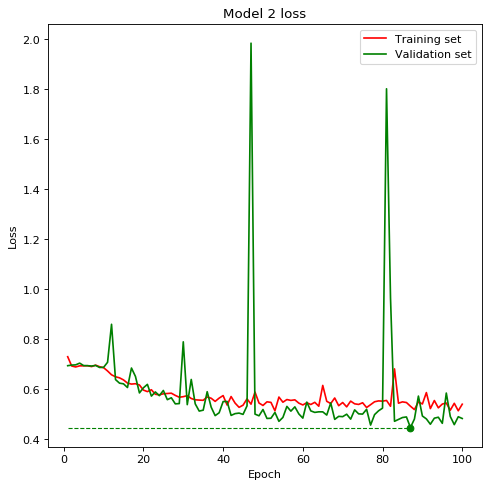

In [0]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 2 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_2, tra_acc_2, 'r', label='Training set')
plt.plot(epochs_2, val_acc_2, 'g', label='Validation set')
plt.plot(opt_epoch_2, val_acc_2[opt_epoch_2-1], 'go')
plt.vlines(opt_epoch_2, min(val_acc_2), opt_val_acc_2, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_2, 1, opt_epoch_2, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 2 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_2, tra_loss_2, 'r', label='Training set')
plt.plot(epochs_2, val_loss_2, 'g', label='Validation set')
plt.plot(opt_epoch_2, val_loss_2[opt_epoch_2-1], 'go')
plt.vlines(opt_epoch_2, min(val_loss_2), opt_val_loss_2, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_2, 1, opt_epoch_2, linestyle="dashed", color='g', linewidth=1)
plt.legend();

**Result**: thanks to data augmentation, overfitting is no longer present, as both training and validation loss decreased over time (with some noise). 
The accuracy slightly dropped because augmentation makes the learning task harder by design, however the network kept learning during the whole run, as the training accuracy suggests; actually, after 100 epochs, there was still room for improvement. In the future experiments, a smarter strategy will be adopted to choose the number of epochs, to avoid halting the training too early.
Two more considerations can be made. First, the optimization process was quite noisy, which could be a symptom of a too small batch size.
Second, the validation accuracy was consistently greater than the training one, although the network did not learn from the validation images. This benign effect is often caused by dropout: that layer is indeed disabled when evaluating the accuracy on the validation set, so the output neuron can exploit more information thus producing a more reliable result.

## Experiment 3

Model 3 introduces some changes both in the model architecture and the optimization process.

The layout differences w.r.t. the previous model are:

*   One more convolutional block. The number of filters is 128, so the information volume drop remains limited
*   The fully-connected layer now has twice more neurons (32)

The batch size is increased (4x) to achieve a smoother learning curve. Since it is not possible to know a priori how long it takes to converge towards the optimum, the network is allowed to learn for a very high number of epochs, until the validation accuracy stops decreasing or drops due to overfitting. 
This is **early stopping**, and consists in interrupting the training if the network didn't make any progress recently.



In [0]:
# Model 3

model_3 = models.Sequential()
model_3.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(layers.Flatten())
model_3.add(layers.Dense(32, activation='relu'))
model_3.add(layers.Dropout(0.5))
model_3.add(layers.Dense(1, activation='sigmoid'))

model_3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 36992)            

In [0]:
# Increase batch size
train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

In [0]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=40, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('model_3_2cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
model_3.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_3 = model_3.fit_generator(
        train_generator,
        steps_per_epoch=int(0.8*n_train_img) // 128,
        epochs=500,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save
models.save_model(model_3, 'model_3_2cl_end.h5')
!cp model* "/content/gdrive/My Drive/models/"

Epoch 1/500
 5/16 [========>.....................] - ETA: 2s - loss: 0.6900 - acc: 0.4804
Epoch 00001: val_loss improved from inf to 0.69001, saving model to model_3_2cl_best.h5
16/16 [==============================] - 9s 575ms/step - loss: 0.8834 - acc: 0.5335 - val_loss: 0.6900 - val_acc: 0.4804
Epoch 2/500
 4/16 [======>.......................] - ETA: 3s - loss: 0.6965 - acc: 0.5176
Epoch 00002: val_loss improved from 0.69001 to 0.68976, saving model to model_3_2cl_best.h5
16/16 [==============================] - 6s 353ms/step - loss: 0.6911 - acc: 0.5226 - val_loss: 0.6898 - val_acc: 0.5215
Epoch 3/500
 4/16 [======>.......................] - ETA: 4s - loss: 0.6904 - acc: 0.5820
Epoch 00003: val_loss improved from 0.68976 to 0.68576, saving model to model_3_2cl_best.h5
16/16 [==============================] - 6s 357ms/step - loss: 0.6903 - acc: 0.5544 - val_loss: 0.6858 - val_acc: 0.5925
Epoch 4/500
 4/16 [======>.......................] - ETA: 4s - loss: 0.6965 - acc: 0.5176
Epoch

In [0]:
# History of accuracy and loss
tra_loss_3 = history_3.history['loss']
tra_acc_3 = history_3.history['acc']
val_loss_3 = history_3.history['val_loss']
val_acc_3 = history_3.history['val_acc']

# Total number of epochs training
epochs_3 = range(1, len(tra_acc_3)+1)
end_epoch_3 = len(tra_acc_3)

# Epoch when reached the validation loss minimum
opt_epoch_3 = val_loss_3.index(min(val_loss_3)) + 1

# Loss and accuracy on the validation set
end_val_loss_3 = val_loss_3[-1]
end_val_acc_3 = val_acc_3[-1]
opt_val_loss_3 = val_loss_3[opt_epoch_3-1]
opt_val_acc_3 = val_acc_3[opt_epoch_3-1]

# Loss and accuracy on the test set
opt_model_3 = models.load_model('model_3_2cl_best.h5')
test_loss_3, test_acc_3 = model_3.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_3, opt_test_acc_3 = opt_model_3.evaluate(test_images, test_labels, verbose=False)
opt_pred_3 = opt_model_3.predict([test_images, test_labels])
pred_classes_3 = np.rint(opt_pred_3)

print("Model 3\n")

print("Epoch [end]: %d" % end_epoch_3)
print("Epoch [opt]: %d" % opt_epoch_3)
print("Valid accuracy [end]: %.4f" % end_val_acc_3)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_3)
print("Test accuracy [end]:  %.4f" % test_acc_3)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_3)
print("Valid loss [end]: %.4f" % end_val_loss_3)
print("Valid loss [opt]: %.4f" % opt_val_loss_3)
print("Test loss [end]:  %.4f" % test_loss_3)
print("Test loss [opt]:  %.4f" % opt_test_loss_3)

print(classification_report(test_labels, pred_classes_3, digits=4))

Model 3

Epoch [end]: 232
Epoch [opt]: 192
Valid accuracy [end]: 0.8692
Valid accuracy [opt]: 0.8766
Test accuracy [end]:  0.8393
Test accuracy [opt]:  0.8542
Valid loss [end]: 0.2982
Valid loss [opt]: 0.2489
Test loss [end]:  0.4663
Test loss [opt]:  0.3645
              precision    recall  f1-score   support

           0     0.8824    0.8380    0.8596       179
           1     0.8253    0.8726    0.8483       157

    accuracy                         0.8542       336
   macro avg     0.8538    0.8553    0.8539       336
weighted avg     0.8557    0.8542    0.8543       336



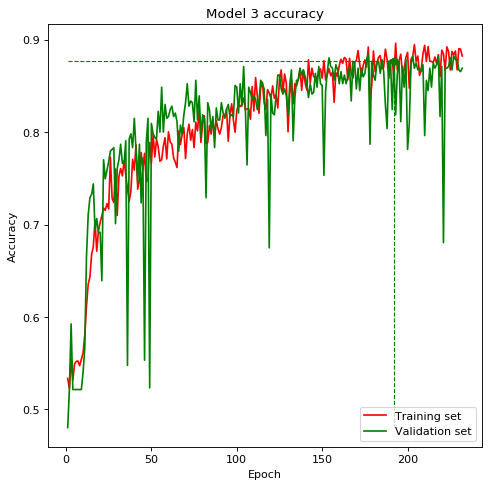

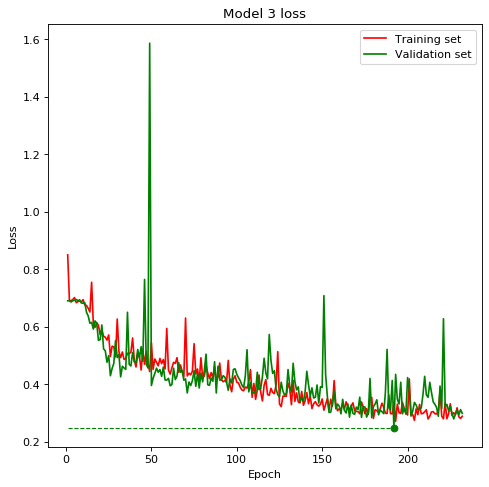

In [0]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 3 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_3, tra_acc_3, 'r', label='Training set')
plt.plot(epochs_3, val_acc_3, 'g', label='Validation set')
plt.plot(opt_epoch_3, val_acc_3[opt_epoch_3-1], 'go')
plt.vlines(opt_epoch_3, min(val_acc_3), opt_val_acc_3, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_3, 1, opt_epoch_3, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 3 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_3, tra_loss_3, 'r', label='Training set')
plt.plot(epochs_3, val_loss_3, 'g', label='Validation set')
plt.plot(opt_epoch_3, val_loss_3[opt_epoch_3-1], 'go')
plt.vlines(opt_epoch_3, min(val_loss_3), opt_val_loss_3, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_3, 1, opt_epoch_3, linestyle="dashed", color='g', linewidth=1)
plt.legend();

**Result**: overall the network scored a 85.4\% accuracy on the test set and 87.7\% on the validation one, a big improvement compared to previous models.
Although the training is still noisy, overfitting is not a major issue anymore.
In this and the previous examples the testing accuracy turned to be consistently lower than the validation one.
This could be either due to a statistical fluctuation (1\% means as few as 3 images), or because the testing set contains slightly more challenging samples than the validation one.

## Experiment 4

Model 4 evolves from Model 3:

*   The number of FC layer neurons is further increased (to 48)

The aim is to verify whether the fully-connected layer size, where most of the weights are located, represents a bottleneck.

Also, the earlystopping patience has been increased since positive fluctuations seem to occur every 40-50 epochs on average, based on the previous graph.



In [0]:
# Model 4

model_4 = models.Sequential()
model_4.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model_4.add(layers.MaxPooling2D((2, 2)))
model_4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))
model_4.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))
model_4.add(layers.Flatten())
model_4.add(layers.Dense(48, activation='relu'))
model_4.add(layers.Dropout(0.5))
model_4.add(layers.Dense(1, activation='sigmoid'))

model_4.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 36992)            

In [0]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=80, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('model_4_2cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
model_4.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_4 = model_4.fit_generator(
        train_generator,
        steps_per_epoch=int(0.8*n_train_img) // 128,
        epochs=500,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save
models.save_model(model_4, 'model_4_2cl_end.h5')
!cp model* "/content/gdrive/My Drive/models/"

Epoch 1/500
 4/16 [======>.......................] - ETA: 2s - loss: 0.6905 - acc: 0.5469
Epoch 00001: val_loss improved from inf to 0.69118, saving model to model_4_2cl_best.h5
16/16 [==============================] - 5s 292ms/step - loss: 1.0773 - acc: 0.5152 - val_loss: 0.6912 - val_acc: 0.5439
Epoch 2/500
 4/16 [======>.......................] - ETA: 3s - loss: 0.6884 - acc: 0.5469
Epoch 00002: val_loss improved from 0.69118 to 0.68942, saving model to model_4_2cl_best.h5
16/16 [==============================] - 4s 260ms/step - loss: 0.6918 - acc: 0.5355 - val_loss: 0.6894 - val_acc: 0.5439
Epoch 3/500
 4/16 [======>.......................] - ETA: 3s - loss: 0.6888 - acc: 0.5469
Epoch 00003: val_loss did not improve from 0.68942
16/16 [==============================] - 4s 257ms/step - loss: 0.6992 - acc: 0.5390 - val_loss: 0.6897 - val_acc: 0.5439
Epoch 4/500
 4/16 [======>.......................] - ETA: 4s - loss: 0.6892 - acc: 0.5469
Epoch 00004: val_loss improved from 0.68942 to

In [0]:
# History of accuracy and loss
tra_loss_4 = history_4.history['loss']
tra_acc_4 = history_4.history['acc']
val_loss_4 = history_4.history['val_loss']
val_acc_4 = history_4.history['val_acc']

# Total number of epochs training
epochs_4 = range(1, len(tra_acc_4)+1)
end_epoch_4 = len(tra_acc_4)

# Epoch when reached the validation loss minimum
opt_epoch_4 = val_loss_4.index(min(val_loss_4)) + 1

# Loss and accuracy on the validation set
end_val_loss_4 = val_loss_4[-1]
end_val_acc_4 = val_acc_4[-1]
opt_val_loss_4 = val_loss_4[opt_epoch_4-1]
opt_val_acc_4 = val_acc_4[opt_epoch_4-1]

# Loss and accuracy on the test set
opt_model_4 = models.load_model('model_4_2cl_best.h5')
test_loss_4, test_acc_4 = model_4.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_4, opt_test_acc_4 = opt_model_4.evaluate(test_images, test_labels, verbose=False)
opt_pred_4 = opt_model_4.predict([test_images, test_labels])
pred_classes_4 = np.rint(opt_pred_4)

print("Model 4\n")

print("Epoch [end]: %d" % end_epoch_4)
print("Epoch [opt]: %d" % opt_epoch_4)
print("Valid accuracy [end]: %.4f" % end_val_acc_4)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_4)
print("Test accuracy [end]:  %.4f" % test_acc_4)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_4)
print("Valid loss [end]: %.4f" % end_val_loss_4)
print("Valid loss [opt]: %.4f" % opt_val_loss_4)
print("Test loss [end]:  %.4f" % test_loss_4)
print("Test loss [opt]:  %.4f" % opt_test_loss_4)

print(classification_report(test_labels, pred_classes_4, digits=4))

Model 4

Epoch [end]: 500
Epoch [opt]: 470
Valid accuracy [end]: 0.8673
Valid accuracy [opt]: 0.8897
Test accuracy [end]:  0.8244
Test accuracy [opt]:  0.8750
Valid loss [end]: 0.3179
Valid loss [opt]: 0.2251
Test loss [end]:  0.4010
Test loss [opt]:  0.3332
              precision    recall  f1-score   support

           0     0.8549    0.9218    0.8871       179
           1     0.9021    0.8217    0.8600       157

    accuracy                         0.8750       336
   macro avg     0.8785    0.8717    0.8735       336
weighted avg     0.8770    0.8750    0.8744       336



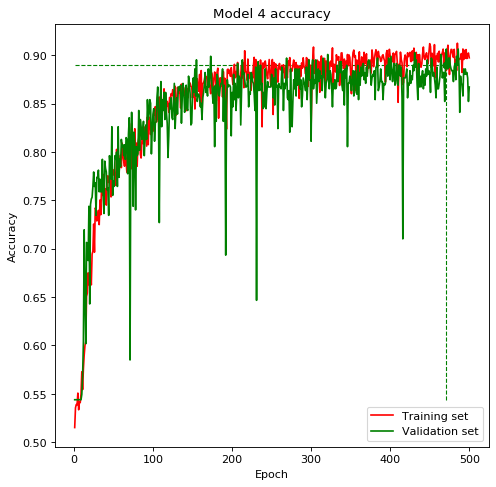

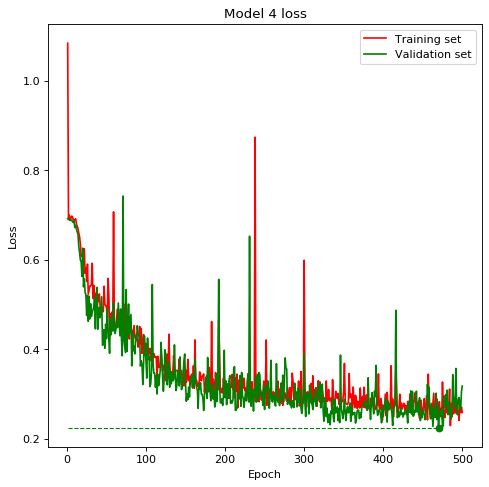

In [0]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 4 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_4, tra_acc_4, 'r', label='Training set')
plt.plot(epochs_4, val_acc_4, 'g', label='Validation set')
plt.plot(opt_epoch_4, val_acc_4[opt_epoch_4-1], 'go')
plt.vlines(opt_epoch_4, min(val_acc_4), opt_val_acc_4, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_4, 1, opt_epoch_4, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 4 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_4, tra_loss_4, 'r', label='Training set')
plt.plot(epochs_4, val_loss_4, 'g', label='Validation set')
plt.plot(opt_epoch_4, val_loss_4[opt_epoch_4-1], 'go')
plt.vlines(opt_epoch_4, min(val_loss_4), opt_val_loss_4, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_4, 1, opt_epoch_4, linestyle="dashed", color='g', linewidth=1)
plt.legend();

**Result**: Increasing the FC layer size positively affected the network performance (2\% accuracy gain w.r.t. the previous model), eventually achieving a solid 87.5\% accuracy on the test set. This result is in-line with the accuracy achieved by state-of-the-art architectures like VGG16, as confirmed in this and other studies.

## Experiment 5

One problem of the previous experiments was the noisy loss and accuracy history. The large fluctuations occur because the weight updates are relatively large, even when the global minimum is very close. This degree of freedom is not a malus per se, especially in the early phase, when the exploration helps avoiding local minima.

Model 5 attempts to balance exploration and exploitation by the mean of a ***learning rate decay*** factor, which reduces the learning rate over time.

In [0]:
# Model 5

model_5 = models.Sequential()
model_5.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model_5.add(layers.MaxPooling2D((2, 2)))
model_5.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_5.add(layers.MaxPooling2D((2, 2)))
model_5.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_5.add(layers.MaxPooling2D((2, 2)))
model_5.add(layers.Flatten())
model_5.add(layers.Dense(48, activation='relu'))
model_5.add(layers.Dropout(0.5))
model_5.add(layers.Dense(1, activation='sigmoid'))

model_5.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 36992)            

In [0]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=80, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('model_5_2cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model (note the decay!)
model_5.compile(optimizer=RMSprop(learning_rate=0.001, decay=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_5 = model_5.fit_generator(
        train_generator,
        steps_per_epoch=int(0.8*n_train_img) // 128,
        epochs=500,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save
models.save_model(model_5, 'model_5_2cl_end.h5')
!cp model* "/content/gdrive/My Drive/models/"

Epoch 1/500
 4/16 [======>.......................] - ETA: 3s - loss: 0.7162 - acc: 0.5410
Epoch 00001: val_loss improved from inf to 0.70793, saving model to model_5_2cl_best.h5
16/16 [==============================] - 6s 363ms/step - loss: 0.7671 - acc: 0.5176 - val_loss: 0.7079 - val_acc: 0.5439
Epoch 2/500
 4/16 [======>.......................] - ETA: 3s - loss: 0.6918 - acc: 0.5410
Epoch 00002: val_loss improved from 0.70793 to 0.69140, saving model to model_5_2cl_best.h5
16/16 [==============================] - 4s 266ms/step - loss: 0.7443 - acc: 0.5474 - val_loss: 0.6914 - val_acc: 0.5439
Epoch 3/500
 4/16 [======>.......................] - ETA: 3s - loss: 0.6887 - acc: 0.5410
Epoch 00003: val_loss improved from 0.69140 to 0.68699, saving model to model_5_2cl_best.h5
16/16 [==============================] - 4s 262ms/step - loss: 0.6913 - acc: 0.5315 - val_loss: 0.6870 - val_acc: 0.5439
Epoch 4/500
 4/16 [======>.......................] - ETA: 4s - loss: 0.6885 - acc: 0.5410
Epoch

In [0]:
# History of accuracy and loss
tra_loss_5 = history_5.history['loss']
tra_acc_5 = history_5.history['acc']
val_loss_5 = history_5.history['val_loss']
val_acc_5 = history_5.history['val_acc']

# Total number of epochs training
epochs_5 = range(1, len(tra_acc_5)+1)
end_epoch_5 = len(tra_acc_5)

# Epoch when reached the validation loss minimum
opt_epoch_5 = val_loss_5.index(min(val_loss_5)) + 1

# Loss and accuracy on the validation set
end_val_loss_5 = val_loss_5[-1]
end_val_acc_5 = val_acc_5[-1]
opt_val_loss_5 = val_loss_5[opt_epoch_5-1]
opt_val_acc_5 = val_acc_5[opt_epoch_5-1]

# Loss and accuracy on the test set
opt_model_5 = models.load_model('model_5_2cl_best.h5')
test_loss_5, test_acc_5 = model_5.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_5, opt_test_acc_5 = opt_model_5.evaluate(test_images, test_labels, verbose=False)
opt_pred_5 = opt_model_5.predict([test_images, test_labels])
pred_classes_5 = np.rint(opt_pred_5)

print("Model 5\n")

print("Epoch [end]: %d" % end_epoch_5)
print("Epoch [opt]: %d" % opt_epoch_5)
print("Valid accuracy [end]: %.4f" % end_val_acc_5)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_5)
print("Test accuracy [end]:  %.4f" % test_acc_5)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_5)
print("Valid loss [end]: %.4f" % end_val_loss_5)
print("Valid loss [opt]: %.4f" % opt_val_loss_5)
print("Test loss [end]:  %.4f" % test_loss_5)
print("Test loss [opt]:  %.4f" % opt_test_loss_5)

print(classification_report(test_labels, pred_classes_5, digits=4))

Model 5

Epoch [end]: 346
Epoch [opt]: 266
Valid accuracy [end]: 0.8785
Valid accuracy [opt]: 0.8972
Test accuracy [end]:  0.8780
Test accuracy [opt]:  0.8869
Valid loss [end]: 0.2658
Valid loss [opt]: 0.2282
Test loss [end]:  0.2951
Test loss [opt]:  0.3048
              precision    recall  f1-score   support

           0     0.9123    0.8715    0.8914       179
           1     0.8606    0.9045    0.8820       157

    accuracy                         0.8869       336
   macro avg     0.8864    0.8880    0.8867       336
weighted avg     0.8881    0.8869    0.8870       336



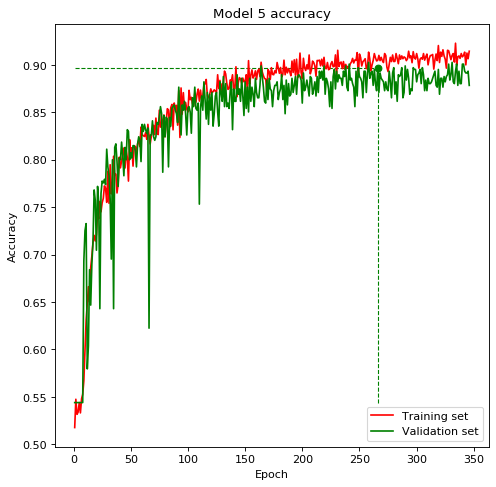

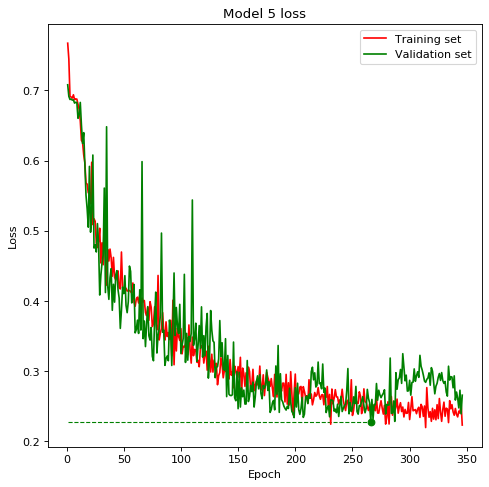

In [0]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 5 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_5, tra_acc_5, 'r', label='Training set')
plt.plot(epochs_5, val_acc_5, 'g', label='Validation set')
plt.plot(opt_epoch_5, val_acc_5[opt_epoch_5-1], 'go')
plt.vlines(opt_epoch_5, min(val_acc_5), opt_val_acc_5, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_5, 1, opt_epoch_5, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 5 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_5, tra_loss_5, 'r', label='Training set')
plt.plot(epochs_5, val_loss_5, 'g', label='Validation set')
plt.plot(opt_epoch_5, val_loss_5[opt_epoch_5-1], 'go')
plt.vlines(opt_epoch_5, min(val_loss_5), opt_val_loss_5, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_5, 1, opt_epoch_5, linestyle="dashed", color='g', linewidth=1)
plt.legend();

**Result**: as expected, the oscillations greatly reduced as a consequence of the learning rate decay. The convergence time is still long, but the testing accuracy increased to almost 89\%.
It is possible to observe a moderate overfitting at the end, caused by the fact that smaller steps make the loss minimum easier to reach.

## Experiment 6


Models 6 is like the previous one, but:

*   An extra convolutional block has been added with 256 features

The purpose of this experiment is to verify if a deeper convolutional stage helps improving the accuracy or not. This strongly depends on the nature of the problem, sometimes it works, sometimes it does not.


In [0]:
# Model 6

model_6 = models.Sequential()
model_6.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model_6.add(layers.MaxPooling2D((2, 2)))
model_6.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_6.add(layers.MaxPooling2D((2, 2)))
model_6.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_6.add(layers.MaxPooling2D((2, 2)))
model_6.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_6.add(layers.MaxPooling2D((2, 2)))
model_6.add(layers.Flatten())
model_6.add(layers.Dense(48, activation='relu'))
model_6.add(layers.Dropout(0.5))
model_6.add(layers.Dense(1, activation='sigmoid'))

model_6.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 15, 15, 256)      

In [0]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=80, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('model_6_2cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model (note the decay!)
model_6.compile(optimizer=RMSprop(learning_rate=0.001, decay=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_6 = model_6.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 128,
        epochs=500,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save
models.save_model(model_6, 'model_6_2cl_end.h5')
!cp model* "/content/gdrive/My Drive/models/"

Epoch 1/500
 5/20 [======>.......................] - ETA: 4s - loss: 0.6905 - acc: 0.5439
Epoch 00001: val_loss improved from inf to 0.69055, saving model to model_6_2cl_best.h5
20/20 [==============================] - 7s 374ms/step - loss: 0.7032 - acc: 0.5293 - val_loss: 0.6905 - val_acc: 0.5439
Epoch 2/500
 5/20 [======>.......................] - ETA: 4s - loss: 0.6898 - acc: 0.5439
Epoch 00002: val_loss improved from 0.69055 to 0.68983, saving model to model_6_2cl_best.h5
20/20 [==============================] - 4s 220ms/step - loss: 0.6927 - acc: 0.5480 - val_loss: 0.6898 - val_acc: 0.5439
Epoch 3/500
 5/20 [======>.......................] - ETA: 4s - loss: 0.6821 - acc: 0.5439
Epoch 00003: val_loss improved from 0.68983 to 0.68213, saving model to model_6_2cl_best.h5
20/20 [==============================] - 5s 235ms/step - loss: 0.6909 - acc: 0.5438 - val_loss: 0.6821 - val_acc: 0.5439
Epoch 4/500
 5/20 [======>.......................] - ETA: 4s - loss: 0.6782 - acc: 0.5439
Epoch

In [0]:
# History of accuracy and loss
tra_loss_6 = history_6.history['loss']
tra_acc_6 = history_6.history['acc']
val_loss_6 = history_6.history['val_loss']
val_acc_6 = history_6.history['val_acc']

# Total number of epochs training
epochs_6 = range(1, len(tra_acc_6)+1)
end_epoch_6 = len(tra_acc_6)

# Epoch when reached the validation loss minimum
opt_epoch_6 = val_loss_6.index(min(val_loss_6)) + 1

# Loss and accuracy on the validation set
end_val_loss_6 = val_loss_6[-1]
end_val_acc_6 = val_acc_6[-1]
opt_val_loss_6 = val_loss_6[opt_epoch_6-1]
opt_val_acc_6 = val_acc_6[opt_epoch_6-1]

# Loss and accuracy on the test set
opt_model_6 = models.load_model('model_6_2cl_best.h5')
test_loss_6, test_acc_6 = model_6.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_6, opt_test_acc_6 = opt_model_6.evaluate(test_images, test_labels, verbose=False)
opt_pred_6 = opt_model_6.predict([test_images, test_labels])
pred_classes_6 = np.rint(opt_pred_6)

print("Model 6\n")

print("Epoch [end]: %d" % end_epoch_6)
print("Epoch [opt]: %d" % opt_epoch_6)
print("Valid accuracy [end]: %.4f" % end_val_acc_6)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_6)
print("Test accuracy [end]:  %.4f" % test_acc_6)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_6)
print("Valid loss [end]: %.4f" % end_val_loss_6)
print("Valid loss [opt]: %.4f" % opt_val_loss_6)
print("Test loss [end]:  %.4f" % test_loss_6)
print("Test loss [opt]:  %.4f" % opt_test_loss_6)

print(classification_report(test_labels, pred_classes_6, digits=4))

Model 6

Epoch [end]: 342
Epoch [opt]: 262
Valid accuracy [end]: 0.8972
Valid accuracy [opt]: 0.8972
Test accuracy [end]:  0.8958
Test accuracy [opt]:  0.8780
Valid loss [end]: 0.2503
Valid loss [opt]: 0.2242
Test loss [end]:  0.3518
Test loss [opt]:  0.3449
              precision    recall  f1-score   support

           0     0.8670    0.9106    0.8883       179
           1     0.8919    0.8408    0.8656       157

    accuracy                         0.8780       336
   macro avg     0.8795    0.8757    0.8769       336
weighted avg     0.8786    0.8780    0.8777       336



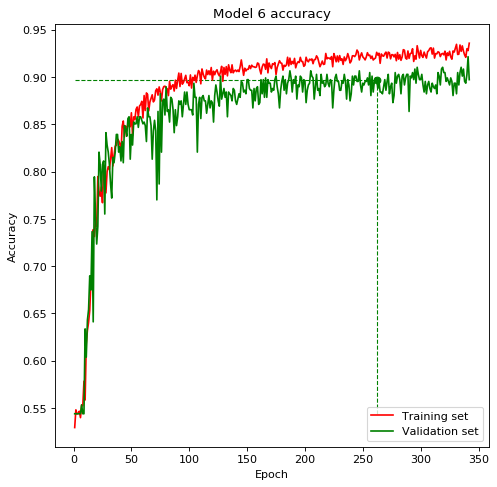

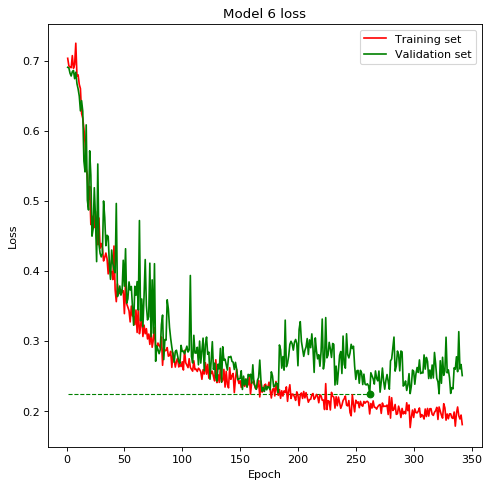

In [0]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 6 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_6, tra_acc_6, 'r', label='Training set')
plt.plot(epochs_6, val_acc_6, 'g', label='Validation set')
plt.plot(opt_epoch_6, val_acc_6[opt_epoch_6-1], 'go')
plt.vlines(opt_epoch_6, min(val_acc_6), opt_val_acc_6, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_6, 1, opt_epoch_6, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 6 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_6, tra_loss_6, 'r', label='Training set')
plt.plot(epochs_6, val_loss_6, 'g', label='Validation set')
plt.plot(opt_epoch_6, val_loss_6[opt_epoch_6-1], 'go')
plt.vlines(opt_epoch_6, min(val_loss_6), opt_val_loss_6, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_6, 1, opt_epoch_6, linestyle="dashed", color='g', linewidth=1)
plt.legend();

**Results**: The addition of another convolutional block reduced the overall number of parameters by a factor 2, without worsening the final accuracy. A smaller model is always a positive thing, as it becomes easier to share and often requires less memory.
It is also interesting to point out that the network started overfitting.

## Experiment 7

Another important parameter that affects the performance of a CNN is the kernel size. A convolution performed by the means of a larger kernel is able to capture details at a larger scale, which can be beneficial in some situations.
Usually, when a CNN uses filters larger than 3x3, the layers are arranged so that larger kernels precede smaller ones, to progressively narrow the receptive field.

Model 7 is very similar Model 4, with one modification:

*   The first conv2D layer now has a 5x5 kernel with stride 2

Note how the changes were minimal and only in the first layer: the assumption is that, if having a larger kernel is beneficial, then a small accuracy improvement should be observed even after a small change like this.
The stride was incremented to avoid excessive overlapping between the receptive fields of adjacent neurons.



In [0]:
# Model 7

model_7 = models.Sequential()
model_7.add(layers.Conv2D(32, (5, 5), strides=(2, 2), activation='relu', input_shape=(150, 150, 1)))
model_7.add(layers.MaxPooling2D((2, 2)))
model_7.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_7.add(layers.MaxPooling2D((2, 2)))
model_7.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_7.add(layers.MaxPooling2D((2, 2)))
model_7.add(layers.Flatten())
model_7.add(layers.Dense(48, activation='relu'))
model_7.add(layers.Dropout(0.5))
model_7.add(layers.Dense(1, activation='sigmoid'))

model_7.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 73, 73, 32)        832       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 15, 15, 128)       73856     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 6272)             

In [0]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=80, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('model_7_2cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model (note the decay!)
model_7.compile(optimizer=RMSprop(learning_rate=0.001, decay=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_7 = model_7.fit_generator(
        train_generator,
        steps_per_epoch=int(0.8*n_train_img) // 128,
        epochs=500,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save
models.save_model(model_7, 'model_7_2cl_end.h5')
!cp model* "/content/gdrive/My Drive/models/"

Epoch 1/500
 4/16 [======>.......................] - ETA: 3s - loss: 0.6927 - acc: 0.5410 
Epoch 00001: val_loss improved from inf to 0.69257, saving model to model_7_2cl_best.h5
16/16 [==============================] - 6s 352ms/step - loss: 0.6997 - acc: 0.5261 - val_loss: 0.6926 - val_acc: 0.5439
Epoch 2/500
 4/16 [======>.......................] - ETA: 3s - loss: 0.6890 - acc: 0.5410
Epoch 00002: val_loss improved from 0.69257 to 0.68694, saving model to model_7_2cl_best.h5
16/16 [==============================] - 4s 248ms/step - loss: 0.6915 - acc: 0.5415 - val_loss: 0.6869 - val_acc: 0.5439
Epoch 3/500
 4/16 [======>.......................] - ETA: 3s - loss: 0.6905 - acc: 0.5410
Epoch 00003: val_loss did not improve from 0.68694
16/16 [==============================] - 4s 245ms/step - loss: 0.6930 - acc: 0.5479 - val_loss: 0.6893 - val_acc: 0.5439
Epoch 4/500
 4/16 [======>.......................] - ETA: 4s - loss: 0.6892 - acc: 0.5410
Epoch 00004: val_loss did not improve from 0.

In [0]:
# History of accuracy and loss
tra_loss_7 = history_7.history['loss']
tra_acc_7 = history_7.history['acc']
val_loss_7 = history_7.history['val_loss']
val_acc_7 = history_7.history['val_acc']

# Total number of epochs training
epochs_7 = range(1, len(tra_acc_7)+1)
end_epoch_7 = len(tra_acc_7)

# Epoch when reached the validation loss minimum
opt_epoch_7 = val_loss_7.index(min(val_loss_7)) + 1

# Loss and accuracy on the validation set
end_val_loss_7 = val_loss_7[-1]
end_val_acc_7 = val_acc_7[-1]
opt_val_loss_7 = val_loss_7[opt_epoch_7-1]
opt_val_acc_7 = val_acc_7[opt_epoch_7-1]

# Loss and accuracy on the test set
opt_model_7 = models.load_model('model_7_2cl_best.h5')
test_loss_7, test_acc_7 = model_7.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_7, opt_test_acc_7 = opt_model_7.evaluate(test_images, test_labels, verbose=False)
opt_pred_7 = opt_model_7.predict([test_images, test_labels])
pred_classes_7 = np.rint(opt_pred_7)

print("Model 7\n")

print("Epoch [end]: %d" % end_epoch_7)
print("Epoch [opt]: %d" % opt_epoch_7)
print("Valid accuracy [end]: %.4f" % end_val_acc_7)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_7)
print("Test accuracy [end]:  %.4f" % test_acc_7)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_7)
print("Valid loss [end]: %.4f" % end_val_loss_7)
print("Valid loss [opt]: %.4f" % opt_val_loss_7)
print("Test loss [end]:  %.4f" % test_loss_7)
print("Test loss [opt]:  %.4f" % opt_test_loss_7)

print(classification_report(test_labels, pred_classes_7, digits=4))

Model 7

Epoch [end]: 333
Epoch [opt]: 253
Valid accuracy [end]: 0.8804
Valid accuracy [opt]: 0.8654
Test accuracy [end]:  0.8780
Test accuracy [opt]:  0.8750
Valid loss [end]: 0.2739
Valid loss [opt]: 0.2473
Test loss [end]:  0.3153
Test loss [opt]:  0.3190
              precision    recall  f1-score   support

           0     0.8703    0.8994    0.8846       179
           1     0.8808    0.8471    0.8636       157

    accuracy                         0.8750       336
   macro avg     0.8755    0.8733    0.8741       336
weighted avg     0.8752    0.8750    0.8748       336



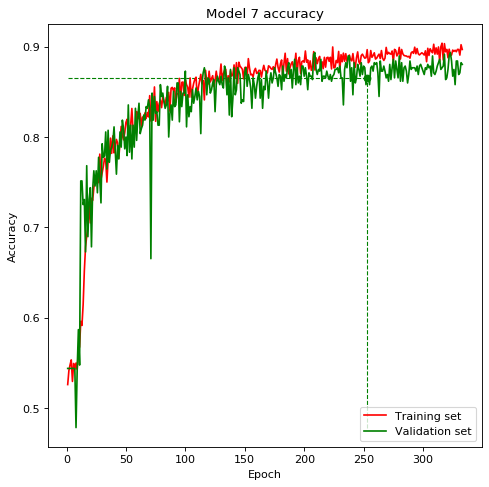

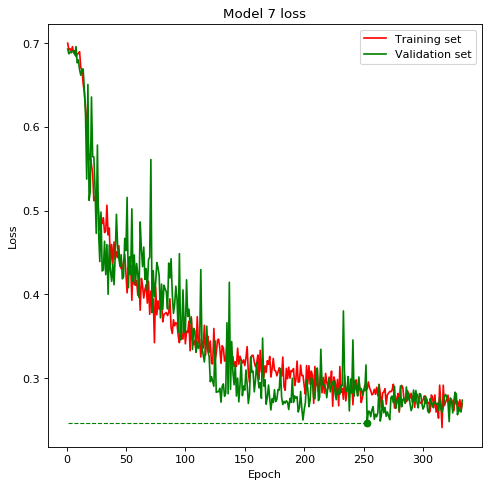

In [0]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 7 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_7, tra_acc_7, 'r', label='Training set')
plt.plot(epochs_7, val_acc_7, 'g', label='Validation set')
plt.plot(opt_epoch_7, val_acc_7[opt_epoch_7-1], 'go')
plt.vlines(opt_epoch_7, min(val_acc_7), opt_val_acc_7, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_7, 1, opt_epoch_7, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 7 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_7, tra_loss_7, 'r', label='Training set')
plt.plot(epochs_7, val_loss_7, 'g', label='Validation set')
plt.plot(opt_epoch_7, val_loss_7[opt_epoch_7-1], 'go')
plt.vlines(opt_epoch_7, min(val_loss_7), opt_val_loss_7, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_7, 1, opt_epoch_7, linestyle="dashed", color='g', linewidth=1)
plt.legend();

**Result**: using a larger kernel size does not help in this specific classification problem. The accuracy did not improve w.r.t. to models with 3x3 filters.

## Experiment 8

So far all the experiments were conducted using RMSprop, which a well-respected optimizer but not necessarily the best choice in every situation. Another popular optimization algorithm is ***Adam***, an extension of the stochastic gradient descent.
The next experiment uses the same architecture of Model 5, but the training is performed by Adam.

In [0]:
# Model 8

model_8 = models.Sequential()
model_8.add(layers.Conv2D(32, (3, 3), activation='relu',  input_shape=(150, 150, 1)))
model_8.add(layers.MaxPooling2D((2, 2)))
model_8.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_8.add(layers.MaxPooling2D((2, 2)))
model_8.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_8.add(layers.MaxPooling2D((2, 2)))
model_8.add(layers.Flatten())
model_8.add(layers.Dense(48, activation='relu'))
model_8.add(layers.Dropout(0.5))
model_8.add(layers.Dense(1, activation='sigmoid'))

model_8.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 36992)            

In [0]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=60, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('model_8_2cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model (note the decay!)
model_8.compile(optimizer=Adam(learning_rate=1e-4, decay=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_8 = model_8.fit_generator(
        train_generator,
        steps_per_epoch=int(0.8*n_train_img) // 128,
        epochs=500,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save
models.save_model(model_8, 'model_8_2cl_end.h5')
!cp model* "/content/gdrive/My Drive/models/"

Epoch 1/500
 4/16 [======>.......................] - ETA: 3s - loss: 0.6904 - acc: 0.5625
Epoch 00001: val_loss improved from inf to 0.69033, saving model to model_8_2cl_best.h5
16/16 [==============================] - 5s 311ms/step - loss: 0.6951 - acc: 0.5211 - val_loss: 0.6903 - val_acc: 0.5626
Epoch 2/500
 4/16 [======>.......................] - ETA: 3s - loss: 0.6874 - acc: 0.5586
Epoch 00002: val_loss improved from 0.69033 to 0.68854, saving model to model_8_2cl_best.h5
16/16 [==============================] - 4s 275ms/step - loss: 0.6899 - acc: 0.5301 - val_loss: 0.6885 - val_acc: 0.5551
Epoch 3/500
 4/16 [======>.......................] - ETA: 3s - loss: 0.6852 - acc: 0.5586
Epoch 00003: val_loss improved from 0.68854 to 0.68677, saving model to model_8_2cl_best.h5
16/16 [==============================] - 4s 276ms/step - loss: 0.6889 - acc: 0.5439 - val_loss: 0.6868 - val_acc: 0.5551
Epoch 4/500
 4/16 [======>.......................] - ETA: 4s - loss: 0.6825 - acc: 0.5586
Epoch

In [0]:
# History of accuracy and loss
tra_loss_8 = history_8.history['loss']
tra_acc_8 = history_8.history['acc']
val_loss_8 = history_8.history['val_loss']
val_acc_8 = history_8.history['val_acc']

# Total number of epochs training
epochs_8 = range(1, len(tra_acc_8)+1)
end_epoch_8 = len(tra_acc_8)

# Epoch when reached the validation loss minimum
opt_epoch_8 = val_loss_8.index(min(val_loss_8)) + 1

# Loss and accuracy on the validation set
end_val_loss_8 = val_loss_8[-1]
end_val_acc_8 = val_acc_8[-1]
opt_val_loss_8 = val_loss_8[opt_epoch_8-1]
opt_val_acc_8 = val_acc_8[opt_epoch_8-1]

# Loss and accuracy on the test set
opt_model_8 = models.load_model('model_8_2cl_best.h5')
test_loss_8, test_acc_8 = model_8.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_8, opt_test_acc_8 = opt_model_8.evaluate(test_images, test_labels, verbose=False)
opt_pred_8 = opt_model_8.predict([test_images, test_labels])
pred_classes_8 = np.rint(opt_pred_8)

print("Model 8\n")

print("Epoch [end]: %d" % end_epoch_8)
print("Epoch [opt]: %d" % opt_epoch_8)
print("Valid accuracy [end]: %.4f" % end_val_acc_8)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_8)
print("Test accuracy [end]:  %.4f" % test_acc_8)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_8)
print("Valid loss [end]: %.4f" % end_val_loss_8)
print("Valid loss [opt]: %.4f" % opt_val_loss_8)
print("Test loss [end]:  %.4f" % test_loss_8)
print("Test loss [opt]:  %.4f" % opt_test_loss_8)

print(classification_report(test_labels, pred_classes_8, digits=4))

Model 8

Epoch [end]: 233
Epoch [opt]: 173
Valid accuracy [end]: 0.8729
Valid accuracy [opt]: 0.8729
Test accuracy [end]:  0.8333
Test accuracy [opt]:  0.8155
Valid loss [end]: 0.3001
Valid loss [opt]: 0.2735
Test loss [end]:  0.4170
Test loss [opt]:  0.3985
              precision    recall  f1-score   support

           0     0.8545    0.7877    0.8198       179
           1     0.7778    0.8471    0.8110       157

    accuracy                         0.8155       336
   macro avg     0.8162    0.8174    0.8154       336
weighted avg     0.8187    0.8155    0.8157       336



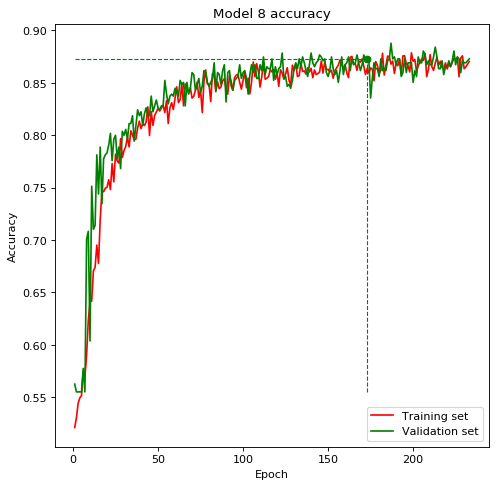

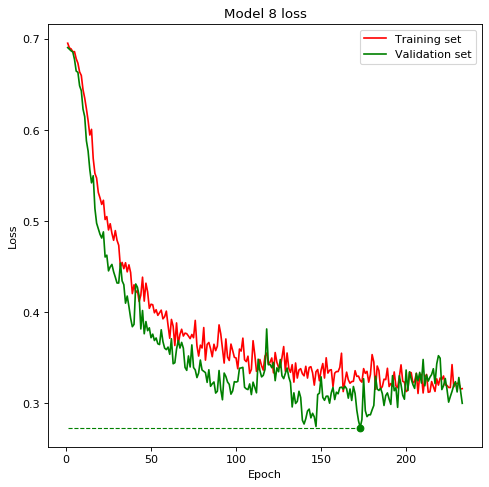

In [0]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 8 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_8, tra_acc_8, 'r', label='Training set')
plt.plot(epochs_8, val_acc_8, 'g', label='Validation set')
plt.plot(opt_epoch_8, val_acc_8[opt_epoch_8-1], 'go')
plt.vlines(opt_epoch_8, min(val_acc_8), opt_val_acc_8, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_8, 1, opt_epoch_8, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 8 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_8, tra_loss_8, 'r', label='Training set')
plt.plot(epochs_8, val_loss_8, 'g', label='Validation set')
plt.plot(opt_epoch_8, val_loss_8[opt_epoch_8-1], 'go')
plt.vlines(opt_epoch_8, min(val_loss_8), opt_val_loss_8, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_8, 1, opt_epoch_8, linestyle="dashed", color='g', linewidth=1)
plt.legend();

**Result**: Compared to RMSprop, Adam oscillates too but without hard spikes; the accuracy graph appears more stable indeed. The downside is in the accuracy itself: although it grows quite fast in the early phase, it settles below the RMSprop level, and the results achieved on the testing set confirm this.

## Experiment 9

This experiment aims at removing the overfitting seen in Model 6, by means of another well-known regularizer: L2.
A small coefficient was chosen to avoid an excessive regularization (that would lead to worse performance), since we already use other techniques like dropout and augmentation.

In [0]:
# Model 9

model_9 = models.Sequential()
model_9.add(layers.Conv2D(32, (3, 3), activation='relu',  input_shape=(150, 150, 1), kernel_regularizer=l2(0.00005)))
model_9.add(layers.MaxPooling2D((2, 2)))
model_9.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.00005)))
model_9.add(layers.MaxPooling2D((2, 2)))
model_9.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.00005)))
model_9.add(layers.MaxPooling2D((2, 2)))
model_9.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.00005)))
model_9.add(layers.MaxPooling2D((2, 2)))
model_9.add(layers.Flatten())
model_9.add(layers.Dense(48, activation='relu'))
model_9.add(layers.Dropout(0.5))
model_9.add(layers.Dense(1, activation='sigmoid'))

model_9.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 15, 15, 256)     

In [0]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=80, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('model_9_2cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
model_9.compile(optimizer=RMSprop(learning_rate=0.001, decay=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_9 = model_9.fit_generator(
        train_generator,
        steps_per_epoch=int(0.8*n_train_img) // 128,
        epochs=500,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save
models.save_model(model_9, 'model_9_2cl_end.h5')
!cp model* "/content/gdrive/My Drive/models/"

Epoch 1/500
 3/16 [====>.........................] - ETA: 5s - loss: 0.6998 - acc: 0.5495 
Epoch 00001: val_loss improved from inf to 0.70022, saving model to model_9_2cl_best.h5
16/16 [==============================] - 7s 441ms/step - loss: 0.8679 - acc: 0.5315 - val_loss: 0.7002 - val_acc: 0.5439
Epoch 2/500
 4/16 [======>.......................] - ETA: 3s - loss: 0.7098 - acc: 0.5469
Epoch 00002: val_loss did not improve from 0.70022
16/16 [==============================] - 4s 259ms/step - loss: 0.7008 - acc: 0.5325 - val_loss: 0.7166 - val_acc: 0.5439
Epoch 3/500
 4/16 [======>.......................] - ETA: 3s - loss: 0.6945 - acc: 0.5469
Epoch 00003: val_loss improved from 0.70022 to 0.69552, saving model to model_9_2cl_best.h5
16/16 [==============================] - 4s 268ms/step - loss: 0.7068 - acc: 0.5604 - val_loss: 0.6955 - val_acc: 0.5439
Epoch 4/500
 4/16 [======>.......................] - ETA: 4s - loss: 0.6968 - acc: 0.5469
Epoch 00004: val_loss did not improve from 0.

In [0]:
# History of accuracy and loss
tra_loss_9 = history_9.history['loss']
tra_acc_9 = history_9.history['acc']
val_loss_9 = history_9.history['val_loss']
val_acc_9 = history_9.history['val_acc']

# Total number of epochs training
epochs_9 = range(1, len(tra_acc_9)+1)
end_epoch_9 = len(tra_acc_9)

# Epoch when reached the validation loss minimum
opt_epoch_9 = val_loss_9.index(min(val_loss_9)) + 1

# Loss and accuracy on the validation set
end_val_loss_9 = val_loss_9[-1]
end_val_acc_9 = val_acc_9[-1]
opt_val_loss_9 = val_loss_9[opt_epoch_9-1]
opt_val_acc_9 = val_acc_9[opt_epoch_9-1]

# Loss and accuracy on the test set
opt_model_9 = models.load_model('model_9_2cl_best.h5')
test_loss_9, test_acc_9 = model_9.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_9, opt_test_acc_9 = opt_model_9.evaluate(test_images, test_labels, verbose=False)
opt_pred_9 = opt_model_9.predict([test_images, test_labels])
pred_classes_9 = np.rint(opt_pred_9)

print("Model 9\n")

print("Epoch [end]: %d" % end_epoch_9)
print("Epoch [opt]: %d" % opt_epoch_9)
print("Valid accuracy [end]: %.4f" % end_val_acc_9)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_9)
print("Test accuracy [end]:  %.4f" % test_acc_9)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_9)
print("Valid loss [end]: %.4f" % end_val_loss_9)
print("Valid loss [opt]: %.4f" % opt_val_loss_9)
print("Test loss [end]:  %.4f" % test_loss_9)
print("Test loss [opt]:  %.4f" % opt_test_loss_9)

print(classification_report(test_labels, pred_classes_9, digits=4))

Model 9

Epoch [end]: 435
Epoch [opt]: 355
Valid accuracy [end]: 0.8579
Valid accuracy [opt]: 0.8822
Test accuracy [end]:  0.8571
Test accuracy [opt]:  0.8810
Valid loss [end]: 0.2651
Valid loss [opt]: 0.2287
Test loss [end]:  0.3309
Test loss [opt]:  0.3329
              precision    recall  f1-score   support

           0     0.8840    0.8939    0.8889       179
           1     0.8774    0.8662    0.8718       157

    accuracy                         0.8810       336
   macro avg     0.8807    0.8800    0.8803       336
weighted avg     0.8809    0.8810    0.8809       336



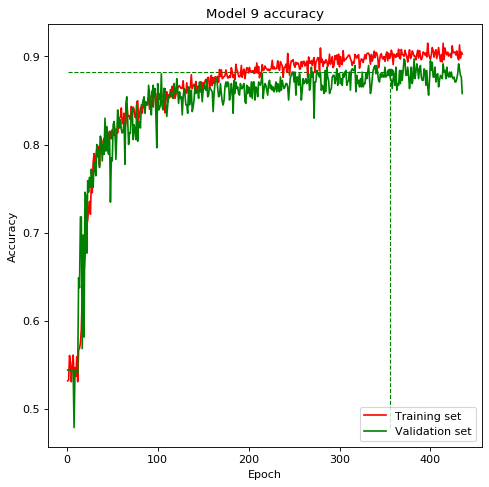

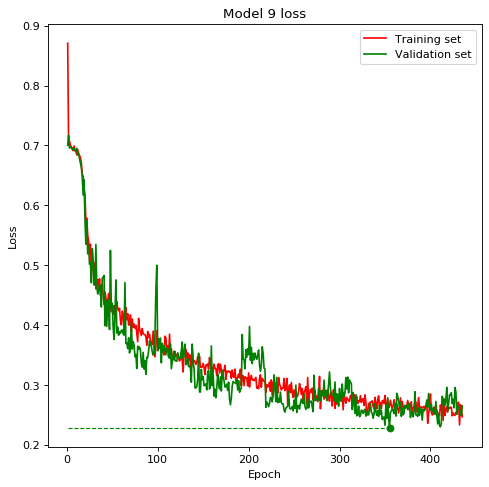

In [0]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 9 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_9, tra_acc_9, 'r', label='Training set')
plt.plot(epochs_9, val_acc_9, 'g', label='Validation set')
plt.plot(opt_epoch_9, val_acc_9[opt_epoch_9-1], 'go')
plt.vlines(opt_epoch_9, min(val_acc_9), opt_val_acc_9, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_9, 1, opt_epoch_9, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 9 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_9, tra_loss_9, 'r', label='Training set')
plt.plot(epochs_9, val_loss_9, 'g', label='Validation set')
plt.plot(opt_epoch_9, val_loss_9[opt_epoch_9-1], 'go')
plt.vlines(opt_epoch_9, min(val_loss_9), opt_val_loss_9, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_9, 1, opt_epoch_9, linestyle="dashed", color='g', linewidth=1)
plt.legend();

**Results**: L2 regularization successfully managed to removed overfitting, so that the validation loss finally matches the training one with no significant deviation.

## Experiment 10

The last experiment aims to test the effects of "batch normalization", a popular technique used to improve the speed, performance and stability of a network. It consists in normalizing (mean and variance) of the inputs to each layer for each mini-batch. 
The final layer is usually excluded from batch normalization, as non-normalized inputs typically help predicting the correct class.

In [0]:
# Model 10

model_10 = models.Sequential()
model_10.add(layers.Conv2D(32, (3, 3), input_shape=(150, 150, 1)))
model_10.add(layers.BatchNormalization())
model_10.add(layers.Activation("relu"))
model_10.add(layers.MaxPooling2D((2, 2)))
model_10.add(layers.Conv2D(64, (3, 3)))
model_10.add(layers.BatchNormalization())
model_10.add(layers.Activation("relu"))
model_10.add(layers.MaxPooling2D((2, 2)))
model_10.add(layers.Conv2D(128, (3, 3)))
model_10.add(layers.BatchNormalization())
model_10.add(layers.Activation("relu"))
model_10.add(layers.MaxPooling2D((2, 2)))
model_10.add(layers.Conv2D(256, (3, 3)))
model_10.add(layers.BatchNormalization())
model_10.add(layers.Activation("relu"))
model_10.add(layers.MaxPooling2D((2, 2)))
model_10.add(layers.Flatten())
model_10.add(layers.Dense(48, activation='relu'))
model_10.add(layers.Dropout(0.5))
model_10.add(layers.Dense(1, activation='sigmoid'))

model_10.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 148, 148, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 72, 72, 64)        256       
_________________________________________

In [0]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=50, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('model_10_2cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model (note the decay!)
model_10.compile(optimizer=RMSprop(learning_rate=0.001, decay=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_10 = model_10.fit_generator(
        train_generator,
        steps_per_epoch=int(0.8*n_train_img) // 128,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save
models.save_model(model_10, 'model_10_2cl_end.h5')
!cp model* "/content/gdrive/My Drive/models/"

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/300
 5/16 [========>.....................] - ETA: 2s - loss: 0.6895 - acc: 0.5757
Epoch 00001: val_loss improved from inf to 0.68946, saving model to model_10_2cl_best.h5
16/16 [==============================] - 10s 653ms/step - loss: 2.5134 - acc: 0.5171 - val_loss: 0.6895 - val_acc: 0.5757
Epoch 2/300
 4/16 [======>.......................] - ETA: 3s - loss: 0.6815 - acc: 0.5742
Epoch 00002: val_loss improved from 0.68946 to 0.68045, saving model to model_10_2cl_best.h5
16/16 [==============================] - 4s 272ms/step - loss: 0.6865 - acc: 0.5415 - val_loss: 0.6804 - val_acc: 0.5757
Epoch 3/300
 4/16 [======>.......................] - ETA: 3s - loss: 0.6905 - acc: 0.5742
Epoch 00003: val_loss did not improve from 0.68045
16/16 [==============================] - 4s 274ms/step - loss: 0.6607 - acc: 0.5450 - val_loss: 0.6905 - val_acc: 0.5757
Epoch 4/300
 4/16 [======>.............

In [0]:
# History of accuracy and loss
tra_loss_10 = history_10.history['loss']
tra_acc_10 = history_10.history['acc']
val_loss_10 = history_10.history['val_loss']
val_acc_10 = history_10.history['val_acc']

# Total number of epochs training
epochs_10 = range(1, len(tra_acc_10)+1)
end_epoch_10 = len(tra_acc_10)

# Epoch when reached the validation loss minimum
opt_epoch_10 = val_loss_10.index(min(val_loss_10)) + 1

# Loss and accuracy on the validation set
end_val_loss_10 = val_loss_10[-1]
end_val_acc_10 = val_acc_10[-1]
opt_val_loss_10 = val_loss_10[opt_epoch_10-1]
opt_val_acc_10 = val_acc_10[opt_epoch_10-1]

# Loss and accuracy on the test set
opt_model_10 = models.load_model('model_10_2cl_best.h5')
test_loss_10, test_acc_10 = model_10.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_10, opt_test_acc_10 = opt_model_10.evaluate(test_images, test_labels, verbose=False)
opt_pred_10 = opt_model_10.predict([test_images, test_labels])
pred_classes_10 = np.rint(opt_pred_10)

print("Model 10\n")

print("Epoch [end]: %d" % end_epoch_10)
print("Epoch [opt]: %d" % opt_epoch_10)
print("Valid accuracy [end]: %.4f" % end_val_acc_10)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_10)
print("Test accuracy [end]:  %.4f" % test_acc_10)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_10)
print("Valid loss [end]: %.4f" % end_val_loss_10)
print("Valid loss [opt]: %.4f" % opt_val_loss_10)
print("Test loss [end]:  %.4f" % test_loss_10)
print("Test loss [opt]:  %.4f" % opt_test_loss_10)

print(classification_report(test_labels, pred_classes_10, digits=4))

Model 10

Epoch [end]: 212
Epoch [opt]: 162
Valid accuracy [end]: 0.8654
Valid accuracy [opt]: 0.9028
Test accuracy [end]:  0.7292
Test accuracy [opt]:  0.8542
Valid loss [end]: 0.3685
Valid loss [opt]: 0.2996
Test loss [end]:  0.5470
Test loss [opt]:  0.4538
              precision    recall  f1-score   support

           0     0.8495    0.8827    0.8658       179
           1     0.8600    0.8217    0.8404       157

    accuracy                         0.8542       336
   macro avg     0.8547    0.8522    0.8531       336
weighted avg     0.8544    0.8542    0.8539       336



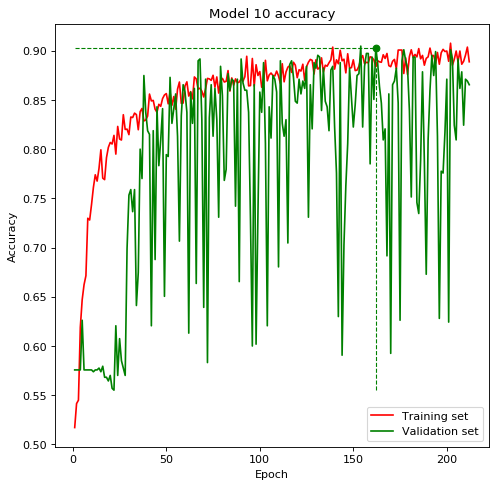

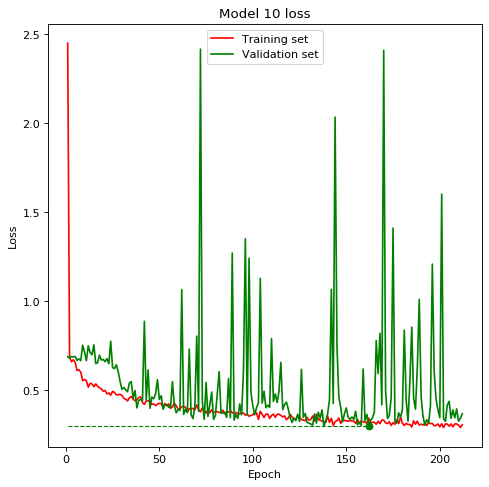

In [0]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 10 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_10, tra_acc_10, 'r', label='Training set')
plt.plot(epochs_10, val_acc_10, 'g', label='Validation set')
plt.plot(opt_epoch_10, val_acc_10[opt_epoch_10-1], 'go')
plt.vlines(opt_epoch_10, min(val_acc_10), opt_val_acc_10, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_10, 1, opt_epoch_10, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 10 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_10, tra_loss_10, 'r', label='Training set')
plt.plot(epochs_10, val_loss_10, 'g', label='Validation set')
plt.plot(opt_epoch_10, val_loss_10[opt_epoch_10-1], 'go')
plt.vlines(opt_epoch_10, min(val_loss_10), opt_val_loss_10, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_10, 1, opt_epoch_10, linestyle="dashed", color='g', linewidth=1)
plt.legend();

**Results**: It is easy to see that batch normalization causes wild oscillations in validation loss and accuracy. Since the BN hyperparameters were left to their default values, this behaviour is probably due to an excessive momentum.

## Experiment 11

This is a replica of the previous experiment, but with a much smaller batch normalization momentum: 0.001.


In [0]:
# Model 11

model_11 = models.Sequential()
model_11.add(layers.Conv2D(32, (3, 3), input_shape=(150, 150, 1)))
model_11.add(layers.BatchNormalization(momentum=0.001))
model_11.add(layers.Activation("relu"))
model_11.add(layers.MaxPooling2D((2, 2)))
model_11.add(layers.Conv2D(64, (3, 3)))
model_11.add(layers.BatchNormalization(momentum=0.001))
model_11.add(layers.Activation("relu"))
model_11.add(layers.MaxPooling2D((2, 2)))
model_11.add(layers.Conv2D(128, (3, 3)))
model_11.add(layers.BatchNormalization(momentum=0.001))
model_11.add(layers.Activation("relu"))
model_11.add(layers.MaxPooling2D((2, 2)))
model_11.add(layers.Conv2D(256, (3, 3)))
model_11.add(layers.BatchNormalization(momentum=0.001))
model_11.add(layers.Activation("relu"))
model_11.add(layers.MaxPooling2D((2, 2)))
model_11.add(layers.Flatten())
model_11.add(layers.Dense(48, activation='relu'))
model_11.add(layers.Dropout(0.5))
model_11.add(layers.Dense(1, activation='sigmoid'))

model_11.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 148, 148, 32)      320       
_________________________________________________________________
batch_normalization_20 (Batc (None, 148, 148, 32)      128       
_________________________________________________________________
activation_20 (Activation)   (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
batch_normalization_21 (Batc (None, 72, 72, 64)        256       
_________________________________________________________________
activation_21 (Activation)   (None, 72, 72, 64)       

In [0]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=50, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('model_11_2cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model (note the decay!)
model_11.compile(optimizer=RMSprop(learning_rate=0.001, decay=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_11 = model_11.fit_generator(
        train_generator,
        steps_per_epoch=int(0.8*n_train_img) // 128,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save
models.save_model(model_11, 'model_11_2cl_end.h5')
!cp model* "/content/gdrive/My Drive/models/"

Epoch 1/300
 4/16 [======>.......................] - ETA: 4s - loss: 0.6616 - acc: 0.6074 
Epoch 00001: val_loss improved from inf to 0.66302, saving model to model_11_2cl_best.h5
16/16 [==============================] - 9s 586ms/step - loss: 1.5641 - acc: 0.5385 - val_loss: 0.6630 - val_acc: 0.6075
Epoch 2/300
 4/16 [======>.......................] - ETA: 3s - loss: 0.6489 - acc: 0.6270
Epoch 00002: val_loss improved from 0.66302 to 0.64685, saving model to model_11_2cl_best.h5
16/16 [==============================] - 4s 271ms/step - loss: 0.6704 - acc: 0.5867 - val_loss: 0.6469 - val_acc: 0.6299
Epoch 3/300
 4/16 [======>.......................] - ETA: 3s - loss: 0.6479 - acc: 0.6562
Epoch 00003: val_loss improved from 0.64685 to 0.64199, saving model to model_11_2cl_best.h5
16/16 [==============================] - 4s 279ms/step - loss: 0.6737 - acc: 0.5847 - val_loss: 0.6420 - val_acc: 0.6542
Epoch 4/300
 4/16 [======>.......................] - ETA: 4s - loss: 0.6352 - acc: 0.6328
E

In [0]:
# History of accuracy and loss
tra_loss_11 = history_11.history['loss']
tra_acc_11 = history_11.history['acc']
val_loss_11 = history_11.history['val_loss']
val_acc_11 = history_11.history['val_acc']

# Total number of epochs training
epochs_11 = range(1, len(tra_acc_11)+1)
end_epoch_11 = len(tra_acc_11)

# Epoch when reached the validation loss minimum
opt_epoch_11 = val_loss_11.index(min(val_loss_11)) + 1

# Loss and accuracy on the validation set
end_val_loss_11 = val_loss_11[-1]
end_val_acc_11 = val_acc_11[-1]
opt_val_loss_11 = val_loss_11[opt_epoch_11-1]
opt_val_acc_11 = val_acc_11[opt_epoch_11-1]

# Loss and accuracy on the test set
opt_model_11 = models.load_model('model_11_2cl_best.h5')
test_loss_11, test_acc_11 = model_11.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_11, opt_test_acc_11 = opt_model_11.evaluate(test_images, test_labels, verbose=False)
opt_pred_11 = opt_model_11.predict([test_images, test_labels])
pred_classes_11 = np.rint(opt_pred_11)

print("Model 11\n")

print("Epoch [end]: %d" % end_epoch_11)
print("Epoch [opt]: %d" % opt_epoch_11)
print("Valid accuracy [end]: %.4f" % end_val_acc_11)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_11)
print("Test accuracy [end]:  %.4f" % test_acc_11)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_11)
print("Valid loss [end]: %.4f" % end_val_loss_11)
print("Valid loss [opt]: %.4f" % opt_val_loss_11)
print("Test loss [end]:  %.4f" % test_loss_11)
print("Test loss [opt]:  %.4f" % opt_test_loss_11)

print(classification_report(test_labels, pred_classes_11, digits=4))

Model 11

Epoch [end]: 100
Epoch [opt]: 50
Valid accuracy [end]: 0.8822
Valid accuracy [opt]: 0.9065
Test accuracy [end]:  0.8661
Test accuracy [opt]:  0.8512
Valid loss [end]: 0.3255
Valid loss [opt]: 0.2304
Test loss [end]:  0.3542
Test loss [opt]:  0.4099
              precision    recall  f1-score   support

           0     0.9329    0.7765    0.8476       179
           1     0.7861    0.9363    0.8547       157

    accuracy                         0.8512       336
   macro avg     0.8595    0.8564    0.8511       336
weighted avg     0.8643    0.8512    0.8509       336



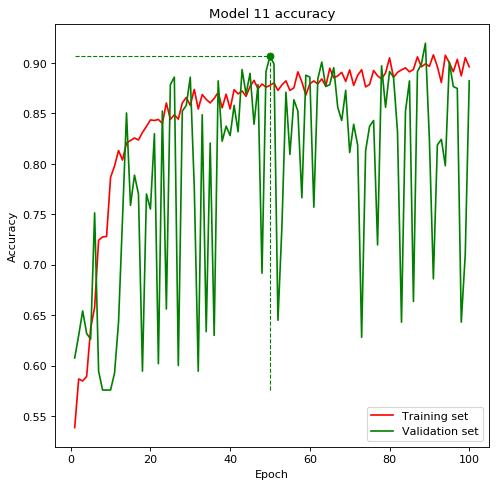

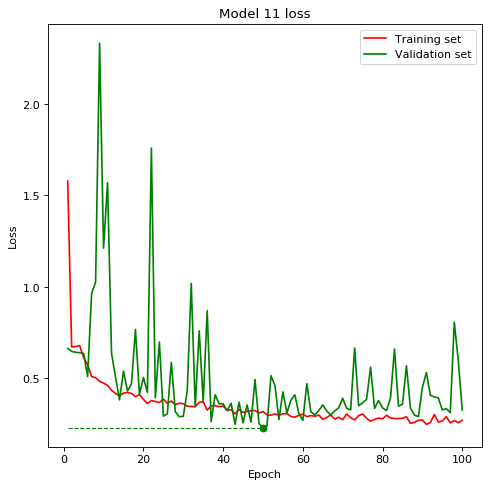

In [0]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 11 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_11, tra_acc_11, 'r', label='Training set')
plt.plot(epochs_11, val_acc_11, 'g', label='Validation set')
plt.plot(opt_epoch_11, val_acc_11[opt_epoch_11-1], 'go')
plt.vlines(opt_epoch_11, min(val_acc_11), opt_val_acc_11, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_11, 1, opt_epoch_11, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 11 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_11, tra_loss_11, 'r', label='Training set')
plt.plot(epochs_11, val_loss_11, 'g', label='Validation set')
plt.plot(opt_epoch_11, val_loss_11[opt_epoch_11-1], 'go')
plt.vlines(opt_epoch_11, min(val_loss_11), opt_val_loss_11, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_11, 1, opt_epoch_11, linestyle="dashed", color='g', linewidth=1)
plt.legend();

**Result**: lowering the momentum decreased the large fluctuations, especially in the final stage. The convergence was faster, and the loss consistently below the average w.r.t. the previous experiments. Nevertheless, the final accuracy did not improve significantly.

Overall, batch normalization seems to be not particularly beneficial in this specific classification task.

# Error analysis

Let's take a look at the results obtained by the previous experiments, especially analyzing the misclassified samples. The aim is to shed some light about these images, and understand why the classifiers predicted the wrong class.
Three (independently trained) models are selected among the best performing ones, according to the previous experiments: Model 5, 6 and 9.

In the following code the term 'misprediction' indicates any sample that led to a wrong label prediction; 'hard misprediction' denotes the mispredictions whose output value differs more than 0.8 from the expected one (e.g. predicted 0.1 when the actual label was 1).

In [0]:
!cp "/content/gdrive/My Drive/models/model_5_2cl_best.h5" .
!cp "/content/gdrive/My Drive/models/model_6_2cl_best.h5" .
!cp "/content/gdrive/My Drive/models/model_9_2cl_best.h5" .

In [0]:
def get_errors(pred):
    errors = []
    mispred = []
    hard_mispred = []

    for l,p,img in zip(test_labels, pred, test_images):
        err = abs(l-p)
        errors.append(err)
        if err > 0.5:
            mispred.append((l,p,img))
        if err > 0.8:
            hard_mispred.append((l,p,img))

    return errors, mispred, hard_mispred


def show_error_stats(errors, mispred, hard_mispred):

    print("Number of test images: %d" % len(test_labels))
    print("Mispredictions: %d" % len(mispred))
    print("Hard mispred: %d" % len(hard_mispred))

    sns.distplot(errors, kde=False, rug=True, bins=10, vertical=False, label='samples', axlabel='error').set_title('Absolute error distribution');

    for l,p,img in hard_mispred:
        plt.figure()
        plt.imshow(img[:,:,0], cmap='gray')
        plt.title('Misclassified as ' + ('mass' if l==0 else 'calcification') + ' with %.2f confidence' % (100*abs(p-l)))
        plt.axis('off')


opt_model_5 = models.load_model('model_5_2cl_best.h5')
opt_model_6 = models.load_model('model_6_2cl_best.h5')
opt_model_9 = models.load_model('model_9_2cl_best.h5')

pred_5 = opt_model_5.predict(test_images)
pred_6 = opt_model_6.predict(test_images)
pred_9 = opt_model_9.predict(test_images)

errors_5, mispred_5, hard_mispred_5 = get_errors(pred_5)
errors_6, mispred_6, hard_mispred_6 = get_errors(pred_6)
errors_9, mispred_9, hard_mispred_9 = get_errors(pred_9)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


**Visual inspection of Model 5 mistakes**

Number of test images: 336
Mispredictions: 38
Hard mispred: 8


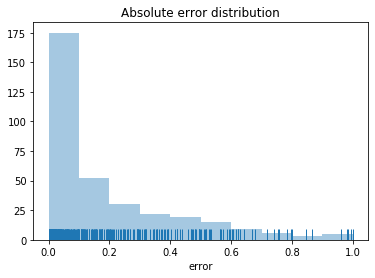

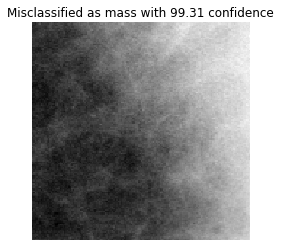

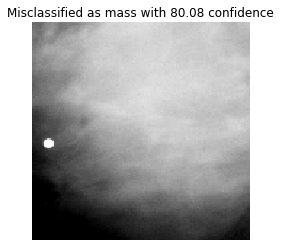

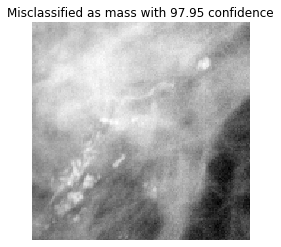

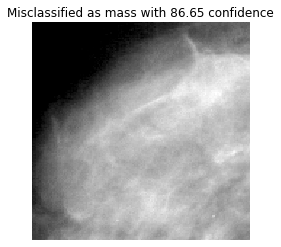

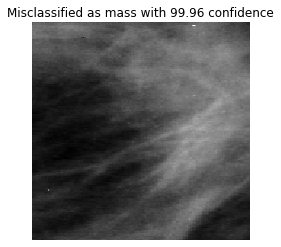

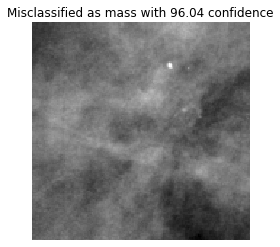

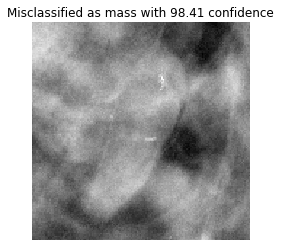

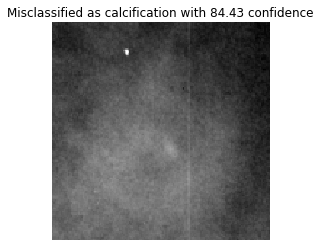

In [0]:
show_error_stats(errors_5, mispred_5, hard_mispred_5)

**Visual inspection of Model 6 mistakes**

Number of test images: 336
Mispredictions: 41
Hard mispred: 19


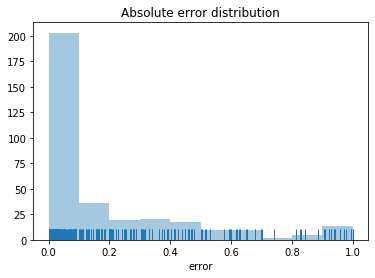

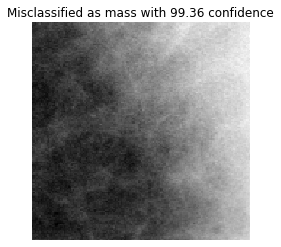

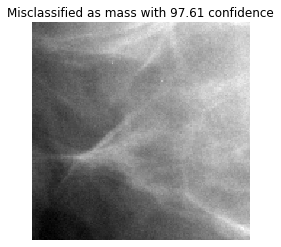

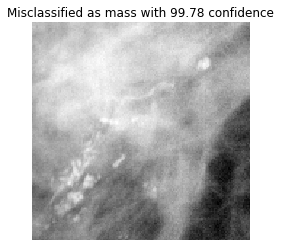

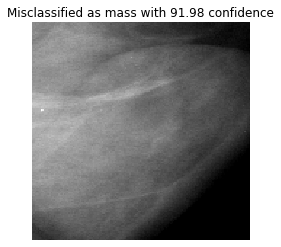

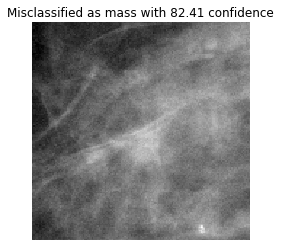

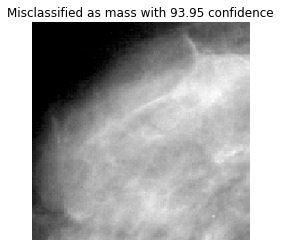

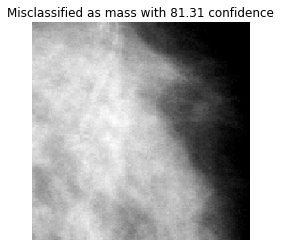

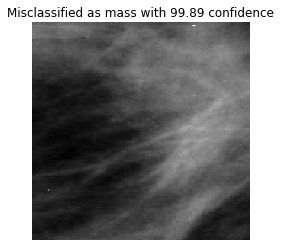

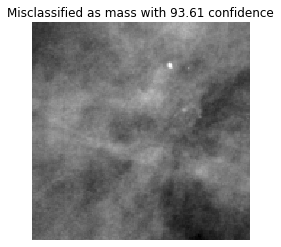

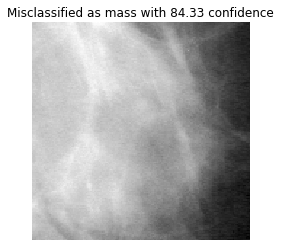

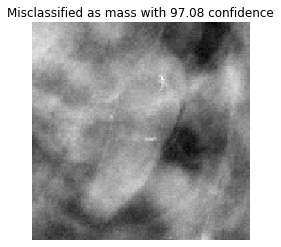

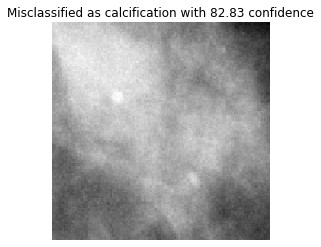

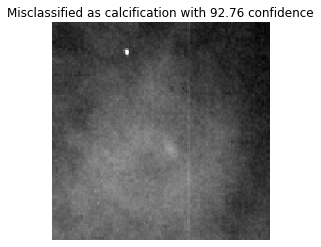

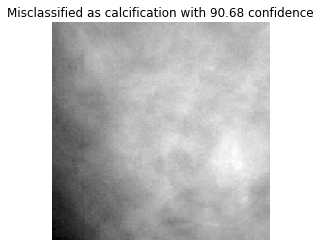

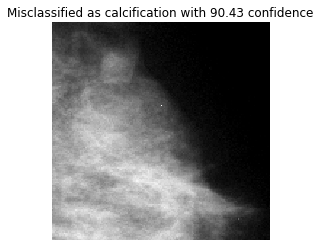

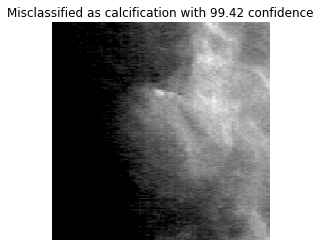

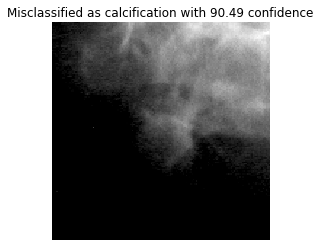

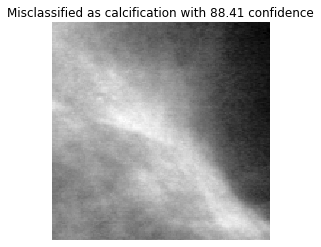

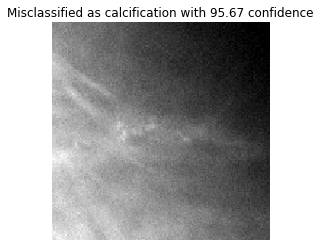

In [0]:
show_error_stats(errors_6, mispred_6, hard_mispred_6)

**Visual inspection of Model 9 mistakes**

Number of test images: 336
Mispredictions: 40
Hard mispred: 16


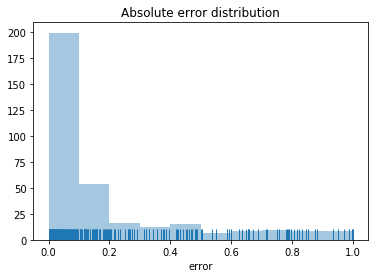

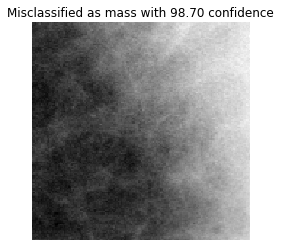

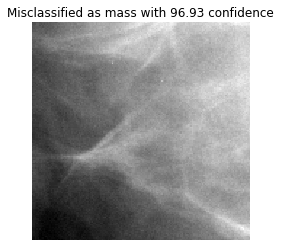

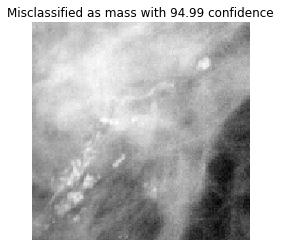

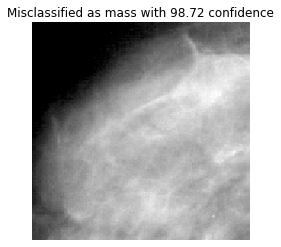

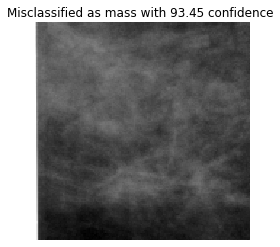

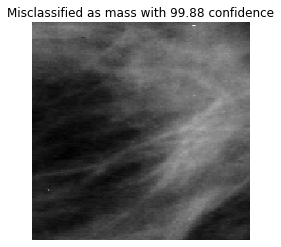

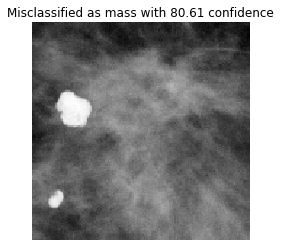

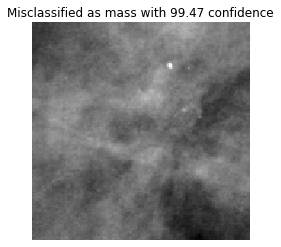

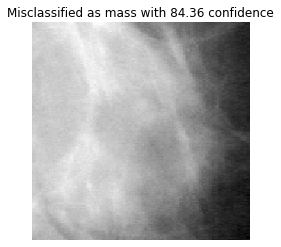

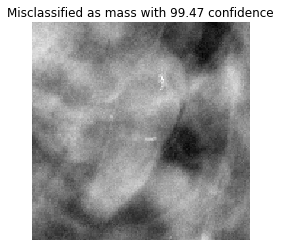

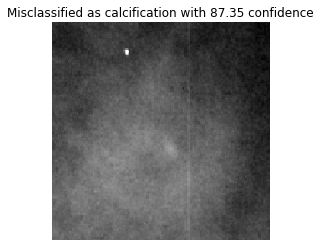

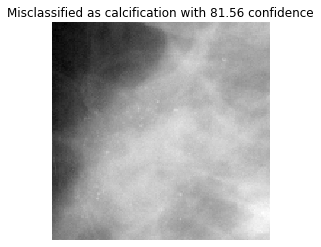

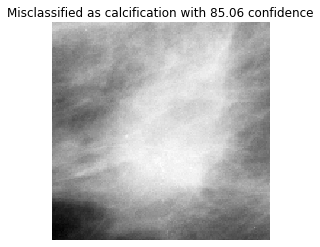

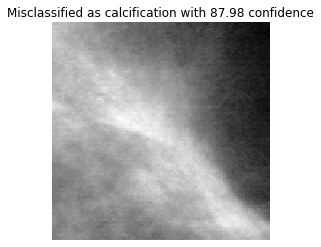

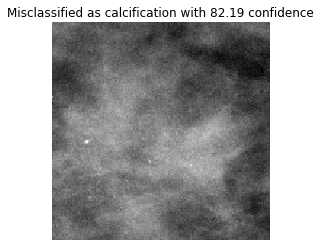

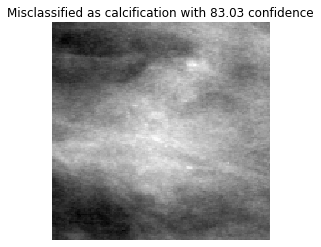

In [0]:
show_error_stats(errors_9, mispred_9, hard_mispred_9)

In [0]:
correct_5 = np.array([abs(p-l) < 0.5 for p,l in zip(np.squeeze(pred_5), test_labels)])
correct_6 = np.array([abs(p-l) < 0.5 for p,l in zip(np.squeeze(pred_6), test_labels)])
correct_9 = np.array([abs(p-l) < 0.5 for p,l in zip(np.squeeze(pred_9), test_labels)])

wrong_5 = np.logical_not(correct_5)
wrong_6 = np.logical_not(correct_6)
wrong_9 = np.logical_not(correct_9)

hard_wrong_5 = np.array([abs(p-l) > 0.8 for p,l in zip(np.squeeze(pred_5), test_labels)])
hard_wrong_6 = np.array([abs(p-l) > 0.8 for p,l in zip(np.squeeze(pred_6), test_labels)])
hard_wrong_9 = np.array([abs(p-l) > 0.8 for p,l in zip(np.squeeze(pred_9), test_labels)])

differ_5_6 = np.logical_xor(correct_5, correct_6)
differ_5_9 = np.logical_xor(correct_5, correct_9)
differ_6_9 = np.logical_xor(correct_6, correct_9)

wrong_all = np.logical_and(wrong_5, wrong_6, wrong_9)
hard_wrong_all = np.logical_and(hard_wrong_5, hard_wrong_6, hard_wrong_9)

In [0]:
print("5 and 6 differ for %d samples" % np.sum(differ_5_6))
print("5 and 9 differ for %d samples" % np.sum(differ_5_9))
print("6 and 9 differ for %d samples" % np.sum(differ_6_9))

print("%d samples were misclassified by all three" % np.sum(wrong_all))
print("%d samples were hard misclassified by all three" % np.sum(hard_wrong_all))

5 and 6 differ for 33 samples
5 and 9 differ for 24 samples
6 and 9 differ for 23 samples
23 samples were misclassified by all three
7 samples were hard misclassified by all three


All the classifiers made some mistakes, but interestingly there are samples that were correctly labeled by one classifier and incorrectly by another.
In other words, even if the accuracy scores are similar and their architectures are similar as well, they behave very differently.

Two dozens of images (approximately 7% of the total) were labeled as belonging to the wrong class by all three classifiers: medically speaking, these are likely to be hard samples to diagnose, where the abnormality appears atypical. On the other side, 93% of the mammograms were correctly classified by at least one model.
The fact that different models produce different results can be exploited to build an ensemble, hopefully able to achieve a greater accuracy than the individual classifiers.

In [0]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

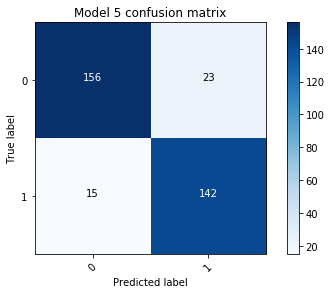

In [0]:
pred_5_classes = np.rint(pred_5)
confusion_mtx = confusion_matrix(test_labels, pred_5_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(2), normalize=False, title='Model 5 confusion matrix')

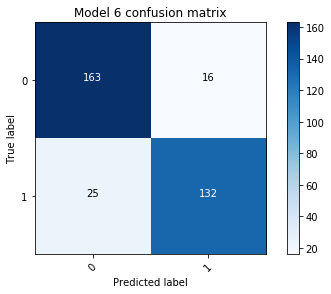

In [0]:
pred_6_classes = np.rint(pred_6)
confusion_mtx = confusion_matrix(test_labels, pred_6_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(2), normalize=False, title='Model 6 confusion matrix')

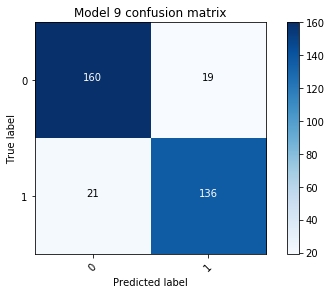

In [0]:
pred_9_classes = np.rint(pred_9)
confusion_mtx = confusion_matrix(test_labels, pred_9_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(2), normalize=False, title='Model 9 confusion matrix')

It is interesting to observe how the errors are distributed in the three classifiers. Model 6 is the best at recognizing masses, but performs slightly worse than the others for calcifications. Model 5 tends to mistakenly classify masses as calcifications rather than viceversa; Model 6 does exactly the opposite; Model 9 mistakes instead are more balanced.

In [0]:
def plot_roc(preds, names, titles='ROC curve'):
    plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
    for pred, name in zip(preds, names):
        fpr, tpr, _ = roc_curve(test_labels, pred)
        auc_keras = auc(fpr, tpr)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr, tpr, label=(name +' (area = {:.3f})'.format(auc_keras)))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='lower right')
    plt.show()

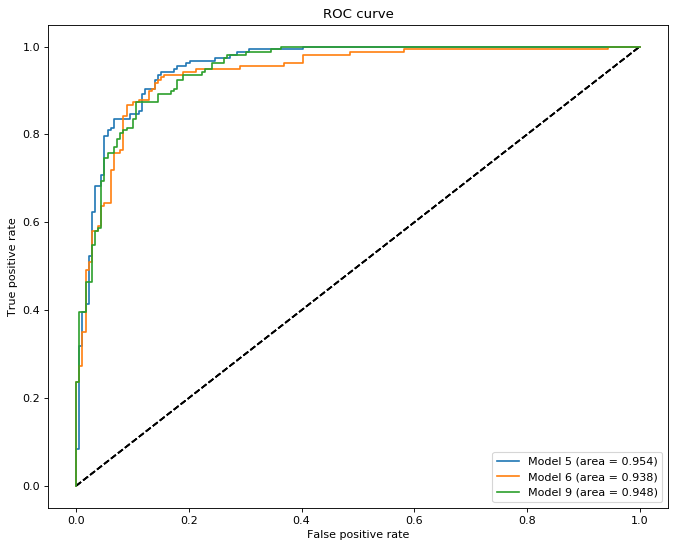

In [0]:
plot_roc([pred_5, pred_6, pred_9], names=['Model 5', 'Model 6', 'Model 9'])

The three ROC curves of models 5, 6 and 9 intersect multiple times, hence none is definitely better than the other; depending on where the threshold separating masses from calcification is set, the three models behave differently.
A metric that is often use to prefer one classifier over another is the AUC (Area Under Curve, the bigger the better): here, model 5 has the largest area (0.954), while Model 6 has the smallest one (0.938).